<a href="https://colab.research.google.com/github/yicongl1/Bordeaux-Airbnb/blob/main/ba08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bordeaux Airbnb: EDA, Visualization, Regression

## Topic Selection
[NYC Airbnb](https://www.kaggle.com/code/wguesdon/nyc-airbnb-eda-visualization-regression)

# 1.Dataset



Instead of using the input of the airbnb project on Kaggle, we dig into the original source of the input.    
[Data source](https://insideairbnb.com/get-the-data/)  
From which we not only get the data of NYC Airbnb, but also of Bordeaux, so we decide to work on the data of Bordeaux.

In [ ]:
# Import all libraries

import pandas as pd # data processing,
import numpy as np # linear algebra
import matplotlib.pyplot as plt # ploting the data
import seaborn as sns # ploting the data
import math # calculation
from scipy import stats #statistics
from collections import Counter

In [ ]:
# Set up color blind friendly color palette
# The palette with grey:
cbPalette = ["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
# The palette with black:
cbbPalette = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

# sns.palplot(sns.color_palette(cbPalette))
# sns.palplot(sns.color_palette(cbbPalette))

sns.set_palette(cbPalette)
#sns.set_palette(cbbPalette)

In [ ]:
# Import data from google drive

from google.colab import drive
#drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

encodings = ['utf-8', 'latin1', 'gbk']
for encoding in encodings:
    try:
        data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BA08/listings.csv', encoding=encoding)
        print(f"Successfully read the file with encoding: {encoding}")
        break
    except UnicodeDecodeError:
        print(f"Failed to read the file with encoding: {encoding}")
else:
    print("Failed to read the file with all tried encodings")

Mounted at /content/drive
Failed to read the file with encoding: utf-8
Successfully read the file with encoding: latin1


In [ ]:
# Visualize data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11854 entries, 0 to 11853
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              11854 non-null  float64
 1   name                            11854 non-null  object 
 2   host_id                         11854 non-null  int64  
 3   host_name                       11854 non-null  object 
 4   neighbourhood_group             11854 non-null  object 
 5   neighbourhood                   11854 non-null  object 
 6   latitude                        11854 non-null  float64
 7   longitude                       11854 non-null  float64
 8   room_type                       11854 non-null  object 
 9   price                           8162 non-null   float64
 10  minimum_nights                  11854 non-null  int64  
 11  number_of_reviews               11854 non-null  int64  
 12  last_review                     

In [ ]:
# Visualize the first 5 rows
data.head()
print(data.iloc[:5, 1])

0    Rental unit in Bordeaux ¡¤ ¡ïNew ¡¤ 2 bedrooms...
1    Rental unit in Bordeaux ¡¤ ¡ïNew ¡¤ 1 bedroom ...
2    Rental unit in Bordeaux ¡¤ ¡ïNew ¡¤ 1 bedroom ...
3    Home in Talence ¡¤ ¡ïNew ¡¤ Studio ¡¤ 1 bed ¡¤...
4    Home in Floirac ¡¤ ¡ïNew ¡¤ 2 bedrooms ¡¤ 2 be...
Name: name, dtype: object


We discovered that there is a column **"name"** which contains the information of **notes**, **number of bedrooms**, **number of beds**, **number of baths** and **type of bath**. We believe the model on price would be more accurate within these infos because it shows the capacity of room, which is a significant factor.
So we extract them into five new columns.

In [ ]:
# Insert five new columns
data.insert(2, 'note', '')
data.insert(3, 'number_of_bedrooms', '')
data.insert(4, 'number_of_beds', '')
data.insert(5, 'number_of_baths', '')
data.insert(6, 'type_of_baths', '')

In [ ]:
#Extract first column: note
note = data['name'].str.extract(r'¡¤ ¡ï([\d\.]+|\w+)')
data['note'] = note.apply(lambda x: float(x[0]) if isinstance(x[0], str) and x[0].replace('.', '', 1).isdigit() else -1 if x[0] == 'New' else None, axis=1)


In [ ]:
#Extract second column: number_of_bedrooms
import re
for index, row in data.iterrows():
    match = re.search(r'([\d\.]+)\s*bedroom', row['name'])
    if match:
        number_of_bedrooms = match.group(1) or match.group(2)
        data.at[index, 'number_of_bedrooms'] = number_of_bedrooms
    elif 'Studio' in row['name']:
        data.at[index, 'number_of_bedrooms'] = 1
    else:
        data.at[index, 'number_of_bedrooms'] = float('nan')

In [ ]:
#Extract second column: number_of_beds
for index, row in data.iterrows():
    match = re.search(r'([\d\.]+)\s*bed\s{1}(?:|$)|([\d\.]+)\s*beds\s{1}(?:|$)', row['name'])
    if match:
        number_of_beds = match.group(1) or match.group(2)
        data.at[index, 'number_of_beds'] = number_of_beds
    else:
        data.at[index, 'number_of_beds'] = float('nan')

In [ ]:
#Extract third and fourth column:: number_of_baths, type_of_baths
for index, row in data.iterrows():
    match = re.search(r'([\d\.]+)\s*bath|([\d\.]+)\s*private\s*bath|([\d\.]+)\s*shared\s*bath', row['name'])
    if match:
        number_of_baths = match.group(1) or match.group(2)
        data.at[index, 'number_of_baths'] = number_of_baths
    elif 'Half-bath' in row['name'] or 'half-bath' in row['name']:
        data.at[index, 'number_of_baths'] = 0.5
    else:
        data.at[index, 'number_of_baths'] = float('nan')
    if 'shared' in row['name']:
        data.at[index, 'type_of_baths'] = 'shared'
    elif pd.notnull(row['number_of_baths']):
        data.at[index, 'type_of_baths'] = 'private'

In [ ]:
print(data.head(10).iloc[:, 2:7])

   note number_of_bedrooms number_of_beds number_of_baths type_of_baths
0  -1.0                  2            NaN               1       private
1  -1.0                  1              1               1       private
2  -1.0                  1              1               1       private
3  -1.0                  1              1               1       private
4  -1.0                  2              2               1       private
5  -1.0                  2              2               1       private
6  -1.0                  1              1               1       private
7  -1.0                  1              1               1       private
8  -1.0                  4              4               3       private
9  -1.0                  1              1               1       private


In [ ]:
print(data.iloc[49:74, 2:7])

    note number_of_bedrooms number_of_beds number_of_baths type_of_baths
49 -1.00                  3              4               2       private
50 -1.00                  1              2               1       private
51   NaN                  1              2               1       private
52  4.50                  1              3               1       private
53  5.00                  2              3               1       private
54   NaN                  1              1               1       private
55 -1.00                  1              1               1       private
56 -1.00                  1              1             1.5       private
57   NaN                  1              1               1       private
58   NaN                  1              1               1       private
59  5.00                  1              3             1.5       private
60  4.89                  1              1               1       private
61  4.54                  2              2         

# 2.Exploratory Data Analysis

In [ ]:
#dropping columns that are not significant or could be unethical to use for our future data exploration and predictions
data.drop(['id','host_name','last_review','license','name'], axis=1, inplace=True)
# Determine the number of missing values for every column
data.isnull().sum()

KeyError: "['id', 'host_name', 'last_review', 'license', 'name'] not found in axis"

Please note that we are dropping'host_name' not only because it is insignificant but also for ethical reasons. There should be no reasoning to continue data exploration and model training (which we will be doing later) towards specific individuals based on their names. Why is that? Those names are assigned to actual humans, also they present no security threat or military/governmental interest based on the nature of the dataset, therefore names are unimportant to us.

In [ ]:
#replace name missing data
data.fillna({'name':0}, inplace=True)
#replacing all NaN values in 'reviews_per_month' with 0
data.fillna({'reviews_per_month':0}, inplace=True)
#drop all rows with NaN values
data = data.dropna(subset=['price','number_of_bedrooms','number_of_beds','number_of_baths','note'] )
data.isnull().sum()

note                              0
number_of_bedrooms                0
number_of_beds                    0
number_of_baths                   0
type_of_baths                     0
host_id                           0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
number_of_reviews_ltm             0
dtype: int64

In [ ]:
#examing the changes
data.head(3)

note  number_of_bedrooms  number_of_beds  number_of_baths type_of_baths  \
2  -1.0                   1               1              1.0       private   
3  -1.0                   1               1              1.0       private   
5  -1.0                   2               2              1.0       private   

     host_id neighbourhood_group                           neighbourhood  \
2  550336355            Bordeaux  Chartrons - Grand Parc - Jardin Public   
3  549947476             Talence                                 Talence   
5  549875028            Bordeaux                            Bordeaux Sud   

    latitude  longitude        room_type  price  minimum_nights  \
2  44.850702  -0.571528  Entire home/apt  120.0               2   
3  44.815874  -0.602802  Entire home/apt   50.0               1   
5  44.829162  -0.573464  Entire home/apt  129.0               1   

   number_of_reviews  reviews_per_month  calculated_host_listings_count  \
2                  0                0.0                               1   
3                  0                0.0                               1   
5                  0                0.0                               1   

   availability_365  number_of_reviews_ltm  
2               242                      0  
3               159                      0  
5                18                      0

In [ ]:
# Transform data type to float
data['number_of_bedrooms'] = pd.to_numeric(data['number_of_bedrooms'], errors='coerce')
data['number_of_beds'] = pd.to_numeric(data['number_of_beds'], errors='coerce')
data['number_of_baths'] = pd.to_numeric(data['number_of_baths'], errors='coerce')

# check dataframe info
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4403 entries, 2 to 11853
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   note                            4403 non-null   float64
 1   number_of_bedrooms              4403 non-null   int64  
 2   number_of_beds                  4403 non-null   int64  
 3   number_of_baths                 4403 non-null   float64
 4   type_of_baths                   4403 non-null   object 
 5   host_id                         4403 non-null   int64  
 6   neighbourhood_group             4403 non-null   object 
 7   neighbourhood                   4403 non-null   object 
 8   latitude                        4403 non-null   float64
 9   longitude                       4403 non-null   float64
 10  room_type                       4403 non-null   object 
 11  price                           4403 non-null   float64
 12  minimum_nights                  4403 n

In [ ]:
# draw histplot
sns.set_palette("muted")

plt.figure(figsize=(20, 15))

plt.subplot(4, 3, 1)
sns.histplot(data['price'])

plt.subplot(4, 3, 2)
sns.histplot(data['minimum_nights'])

plt.subplot(4, 3, 3)
sns.histplot(data['number_of_reviews'])

plt.subplot(4, 3, 4)
sns.histplot(data['reviews_per_month'])

plt.subplot(4, 3, 5)
sns.histplot(data['calculated_host_listings_count'])

plt.subplot(4, 3, 6)
sns.histplot(data['availability_365'])

plt.subplot(4, 3, 7)
sns.histplot(data['number_of_bedrooms'])

plt.subplot(4, 3, 8)
sns.histplot(data['number_of_beds'])

plt.subplot(4, 3, 9)
sns.histplot(data['number_of_baths'])

plt.subplot(4, 3, 10)
sns.histplot(data['number_of_reviews_ltm'])

plt.subplot(4, 3, 11)
sns.histplot(data['note'])

plt.tight_layout()

KeyboardInterrupt: 

In [ ]:
# draw histplot
sns.set_palette("muted")

plt.figure(figsize=(20, 15))

plt.subplot(4, 3, 1)
sns.histplot(data['price'])

plt.subplot(4, 3, 2)
sns.histplot(data['minimum_nights'])

plt.subplot(4, 3, 3)
sns.histplot(data['number_of_reviews'])

plt.subplot(4, 3, 4)
sns.histplot(data['reviews_per_month'])

plt.subplot(4, 3, 5)
sns.histplot(data['calculated_host_listings_count'])

plt.subplot(4, 3, 6)
sns.histplot(data['availability_365'])

plt.subplot(4, 3, 7)
sns.histplot(data['number_of_bedrooms'])

plt.subplot(4, 3, 8)
sns.histplot(data['number_of_beds'])

plt.subplot(4, 3, 9)
sns.histplot(data['number_of_baths'])

plt.subplot(4, 3, 10)
sns.histplot(data['number_of_reviews_ltm'])

plt.subplot(4, 3, 11)
sns.histplot(data['note'])

plt.tight_layout()

In [ ]:
#draw boxplot

plt.figure(figsize=(20, 15))

plt.subplot(4, 3, 1)
sns.boxplot(data['price'])

plt.subplot(4, 3, 2)
sns.boxplot(data['minimum_nights'])

plt.subplot(4, 3, 3)
sns.boxplot(data['number_of_reviews'])

plt.subplot(4, 3, 4)
sns.boxplot(data['reviews_per_month'])

plt.subplot(4, 3, 5)
sns.boxplot(data['calculated_host_listings_count'])

plt.subplot(4, 3, 6)
sns.boxplot(data['availability_365'])

plt.subplot(4, 3, 7)
sns.boxplot(data['number_of_bedrooms'])

plt.subplot(4, 3, 8)
sns.boxplot(data['number_of_beds'])

plt.subplot(4, 3, 9)
sns.boxplot(data['number_of_baths'])

plt.subplot(4, 3, 10)
sns.boxplot(data['number_of_reviews_ltm'])

plt.subplot(4, 3, 11)
sns.boxplot(data['note'])

plt.tight_layout()

In [ ]:
title = 'Properties per Neighbourhood Group'
sns.countplot(data['neighbourhood_group'], order=data['neighbourhood_group'].value_counts().index)
plt.title(title)
plt.show()

*  Most properties are located in Bordeaux.
*  To simplify the
further study, we reserve five neighborhood group with most properties. That is Bordeaux, Merignac, Pessac, Talence, Bgles.

In [ ]:
top_neighbourhood_groups = data['neighbourhood_group'].value_counts().nlargest(5).index

# Filter data by 'neighbourhood_group'
data = data[data['neighbourhood_group'].isin(top_neighbourhood_groups)]
title = 'Properties per Neighbourhood Group'
sns.countplot(data['neighbourhood_group'], order=data['neighbourhood_group'].value_counts().index)
plt.title(title)
plt.show()

In [ ]:
title = 'Properties per Room Type'
sns.countplot(data['room_type'])
plt.title(title)
plt.show()

* Most properties are Entire home or Private room.



# 3.Visualization

## 3.1 Location

In [ ]:
import folium

# Find min and max of latitude
min_latitude = data['latitude'].min()
max_latitude = data['latitude'].max()
# Find min and max of longitude
min_longitude = data['longitude'].min()
max_longitude = data['longitude'].max()

center_lat = (min_latitude + max_latitude) / 2
center_lon = (min_longitude + max_longitude) / 2

# Create the base map
map_neighbourhood_group = folium.Map(location=[center_lat, center_lon], zoom_start=12)  # Adjust the location to the center of your data

# Add points on map
colors_neighbourhood_group = {
    'Bordeaux': 'red',
    'Talence': 'blue',
    'Pessac': 'green',
    'Bgles': 'purple',
    'Merignac': 'orange'
}

for index, row in data.iterrows():
    folium.CircleMarker(
        [row['latitude'], row['longitude']],
        radius=3,
        color=colors_neighbourhood_group.get(row['neighbourhood_group'], 'black'),  # Default color if group not in colors
        fill=True,
        fill_color=colors_neighbourhood_group.get(row['neighbourhood_group'], 'black'),
        fill_opacity=0.7
    ).add_to(map_neighbourhood_group)


# define an HTML model for legend
legend_neighbourhood_group_html = '''
     <div style="position: fixed;
                 bottom: 50px; left: 50px; width: 150px; height: auto;
                 border:2px solid grey; z-index:9999; font-size:14px; line-height: 1.5;
                 background:white;
                 padding:10px;
                 box-shadow: 5px 5px 5px rgba(0,0,0,0.5);">
     <table style="margin: 10px 0px;">
     <tr><td>Bordeaux </td><td><i style="background:red;width:12px;height:12px;border-radius:50%;display:inline-block;"></i></td></tr>
     <tr><td>Talence </td><td><i style="background:blue;width:12px;height:12px;border-radius:50%;display:inline-block;"></i></td></tr>
     <tr><td>Pessac </td><td><i style="background:green;width:12px;height:12px;border-radius:50%;display:inline-block;"></i></td></tr>
     <tr><td>Bègles </td><td><i style="background:purple;width:12px;height:12px;border-radius:50%;display:inline-block;"></i></td></tr>
     <tr><td>Mérignac </td><td><i style="background:orange;width:12px;height:12px;border-radius:50%;display:inline-block;"></i></td></tr>
     </table>
     </div>
 '''

# Instantiate a map
legend_neighbourhood_group = folium.Element(legend_neighbourhood_group_html)
map_neighbourhood_group.get_root().html.add_child(legend_neighbourhood_group)

# show map
map_neighbourhood_group

In [ ]:
# Create the base map
map_room_type = folium.Map(location=[center_lat, center_lon], zoom_start=12)  # Adjust the location to the center of your data

# Add points on the map
colors_room_type = {
    'Entire home/apt': 'red',
    'Private room': 'blue',
    'Hotel room': 'green'
}

for index, row in data.iterrows():
    folium.CircleMarker(
        [row['latitude'], row['longitude']],
        radius=3,
        color=colors_room_type.get(row['room_type'], 'black'),  # Default color if group not in colors
        fill=True,
        fill_color=colors_room_type.get(row['room_type'], 'black'),
        fill_opacity=0.7
    ).add_to(map_room_type)

#define an HTML model for legend
legend_room_type_html = '''
     <div style="position: fixed;
                 bottom: 50px; left: 50px; width: 180px; height: auto;
                 border:2px solid grey; z-index:9999; font-size:14px; line-height: 1.5;
                 background:white;
                 padding:10px;
                 box-shadow: 5px 5px 5px rgba(0,0,0,0.5);">
     <table style="margin: 10px 0px;">
     <tr><td>Entire home/apt</td><td><i style="background:red;width:12px;height:12px;border-radius:50%;display:inline-block;"></i></td></tr>
     <tr><td>Private room</td><td><i style="background:blue;width:12px;height:12px;border-radius:50%;display:inline-block;"></i></td></tr>
     <tr><td>Hotel room</td><td><i style="background:green;width:12px;height:12px;border-radius:50%;display:inline-block;"></i></td></tr>
     </table>
     </div>
 '''

# Instantiate a map
legend_room_type = folium.Element(legend_room_type_html)
map_room_type.get_root().html.add_child(legend_room_type)


# show map
map_room_type

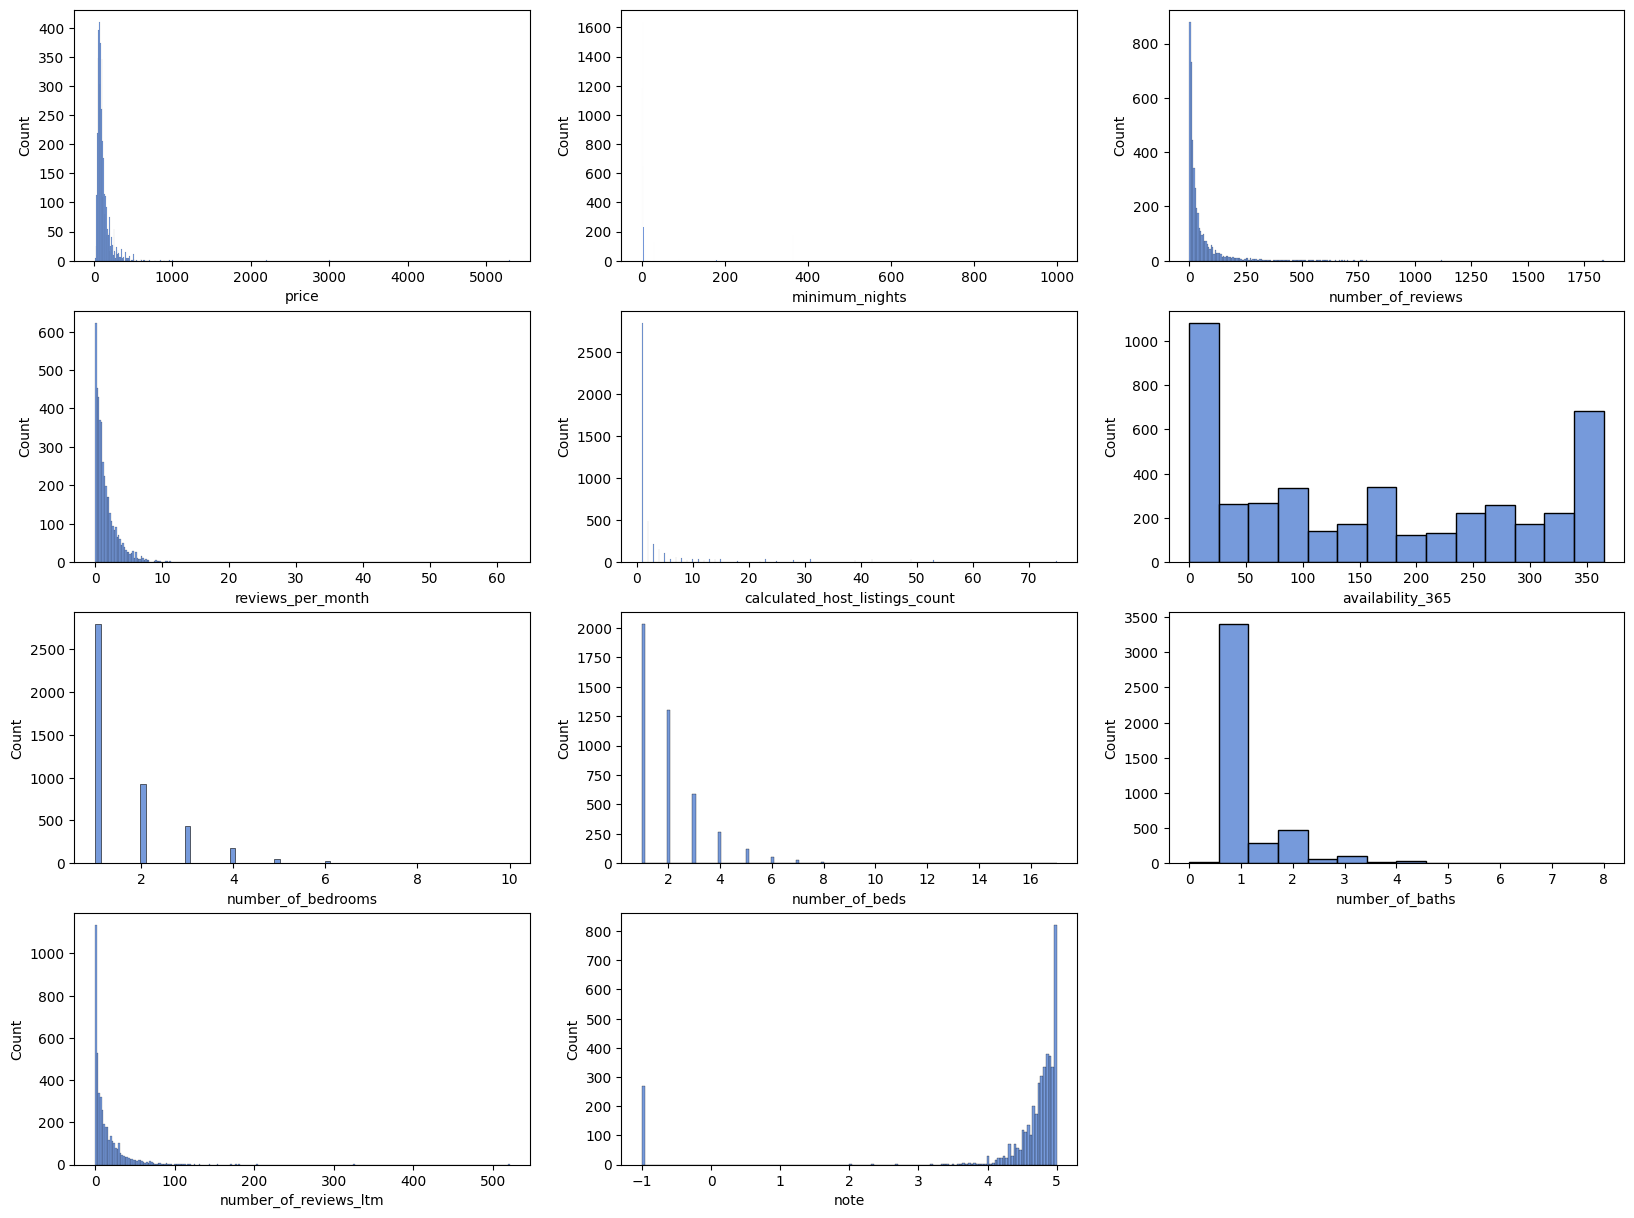

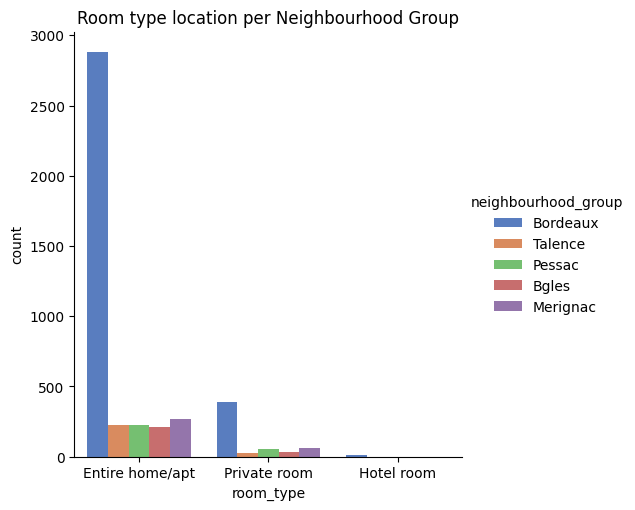

In [ ]:
title = 'Room type location per Neighbourhood Group'
sns.catplot(x='room_type', kind="count", hue="neighbourhood_group", data=data); #生成countplot
plt.title(title)
plt.show()

## 3.2 Correlation

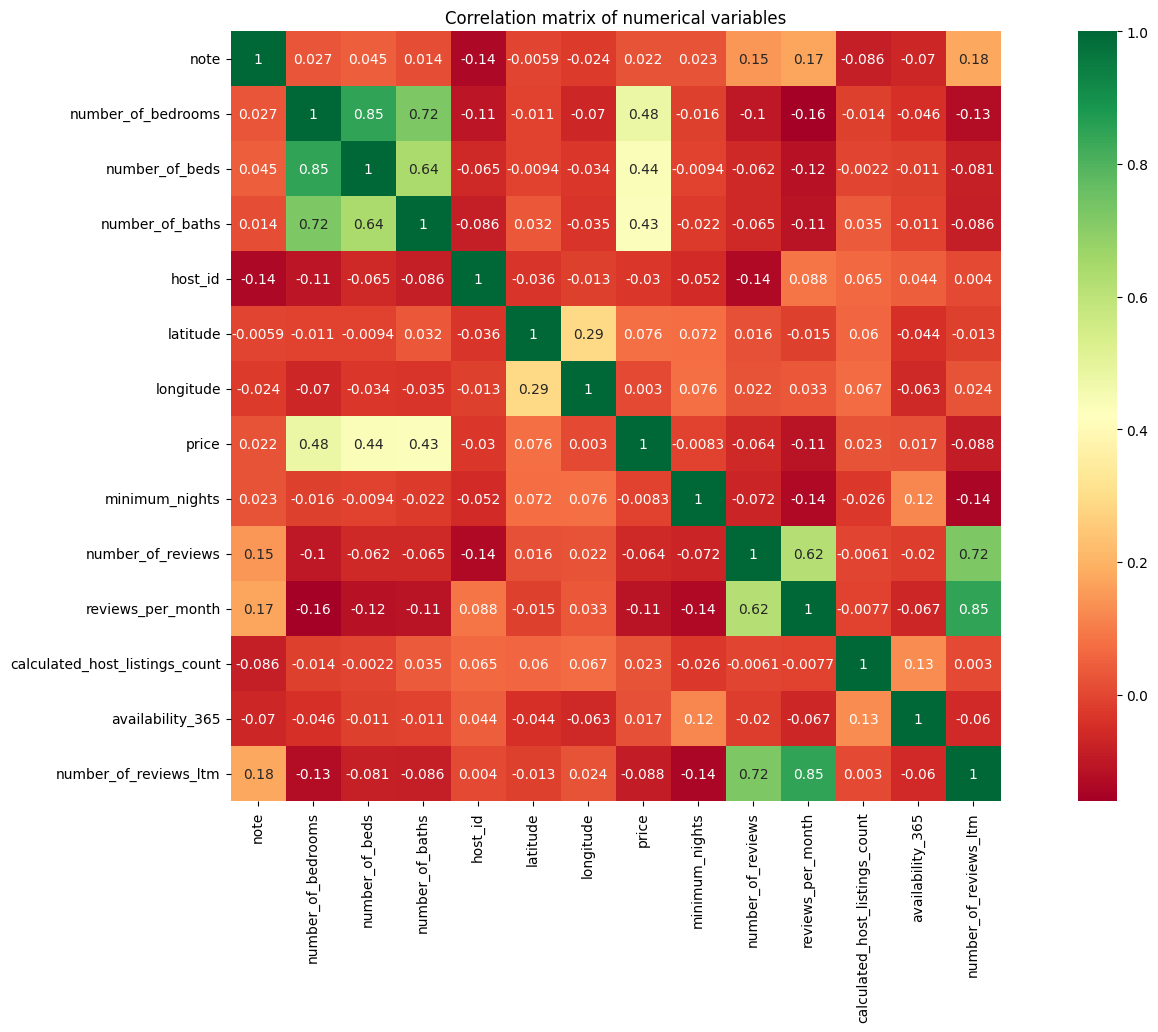

In [ ]:
# Extract columns numeric data
numeric_data = data.select_dtypes(include=[float, int])

# create matrix of correlation
correlation_matrix = numeric_data.corr()

plt.figure(figsize=(20,10))
title = 'Correlation matrix of numerical variables'
#sns.heatmap(numeric_data.corr(), square=True, cmap='RdYlGn')
sns.heatmap(numeric_data.corr(), square=True, cmap='RdYlGn', annot=True)
plt.title(title)
plt.show()

*  To our surprice, we discover that the **price** has good correlation with **number of bedrooms**, **number of beds** and **number of bathrooms**. Which could be our advantage on modeling.

## 3.3 Price relation to Neighbourhood Group

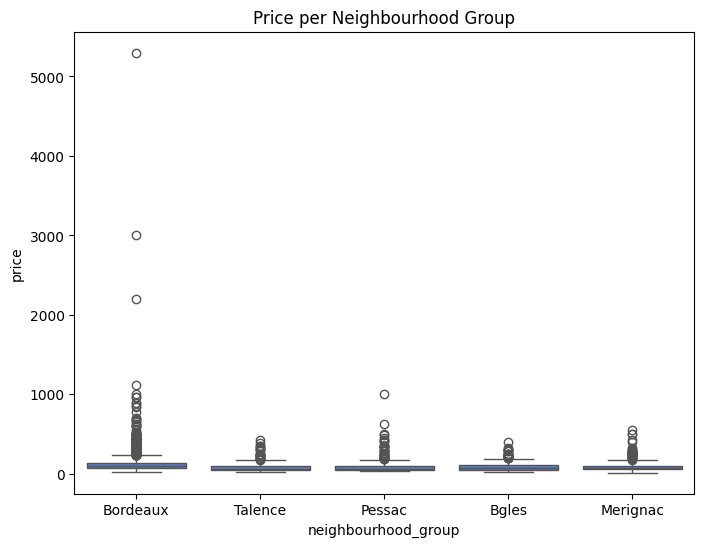

In [ ]:
#https://jakevdp.github.io/PythonDataScienceHandbook/04.14-visualization-with-seaborn.html
#http://seaborn.pydata.org/tutorial/color_palettes.html

x= 'neighbourhood_group'
y= 'price'
title = 'Price per Neighbourhood Group'

f, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=x, y=y, data=data)
plt.title(title)
plt.show()

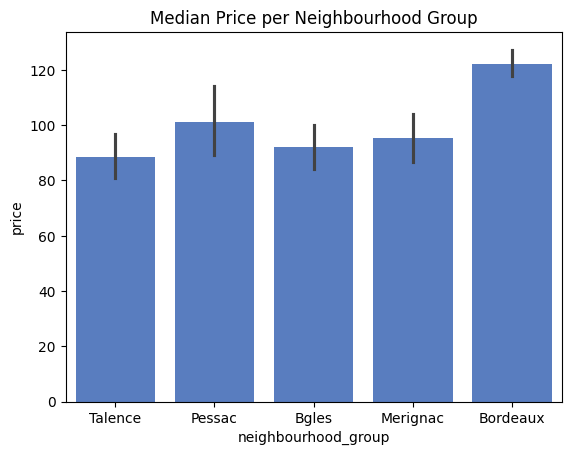

In [ ]:
# alternative visualization of median less impacted by the extreme values
# see https://www.kaggle.com/nidaguler/eda-and-data-visualization-ny-airbnb

title = 'Median Price per Neighbourhood Group'
result = data.groupby(["neighbourhood_group"])['price'].aggregate(np.median).reset_index().sort_values('price')
sns.barplot(x='neighbourhood_group', y="price", data=data, order=result['neighbourhood_group'])
plt.title(title)
plt.show()

* Properties in Bordeaux are more expensive
* The dataset can be separate between low price and high price properties

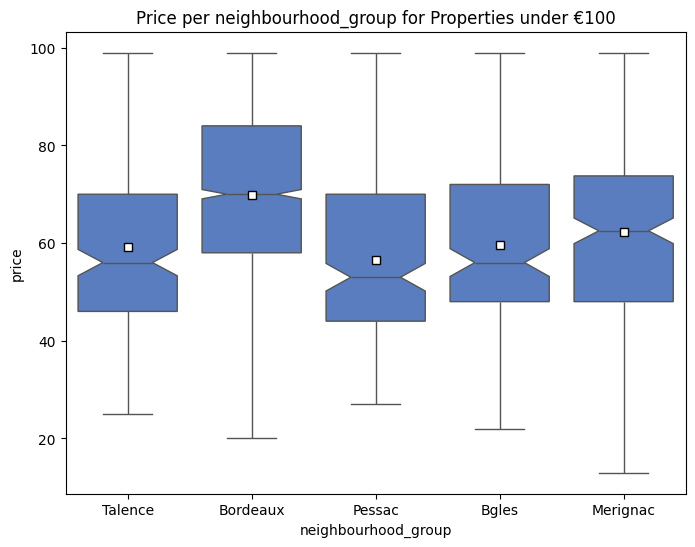

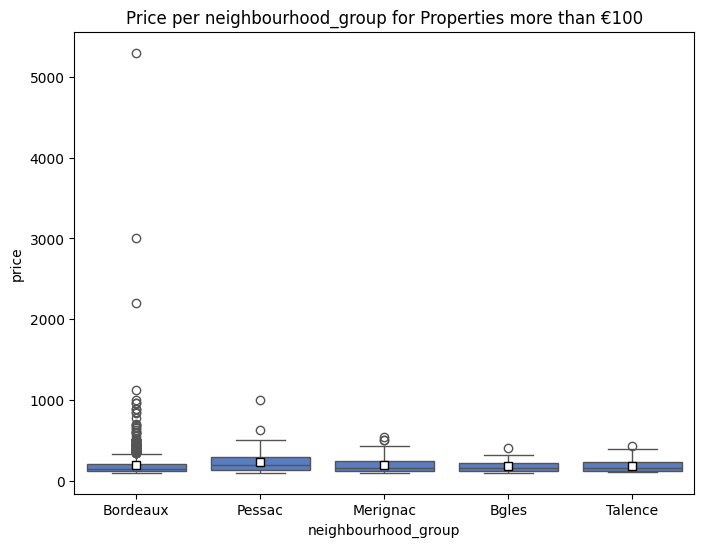

In [ ]:
# https://stackoverflow.com/questions/54132989/is-there-a-way-to-change-the-color-and-shape-indicating-the-mean-in-a-seaborn-bo
x='neighbourhood_group'
y='price'

title = 'Price per neighbourhood_group for Properties under €100'
data_filtered = data.loc[data['price'] < 100]
f, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=x, y=y, data=data_filtered, notch=True, showmeans=True,
           meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"})
plt.title(title)
plt.ioff()
f
title = 'Price per neighbourhood_group for Properties more than €100'
data_filtered = data.loc[data['price'] > 100]
f, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x=x, y=y, data=data_filtered, notch=False, showmeans=True,
           meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"})
plt.title(title)
plt.show()

In [ ]:
# Is the location impact on price statiscaly significant?
# Use on way ANOVA and pairwise comaprison
# See https://www.marsja.se/four-ways-to-conduct-one-way-anovas-using-python/

import statsmodels.api as sm
from statsmodels.formula.api import ols

data_filtered = data.loc[data['price'] < 100]

mod = ols('price ~ neighbourhood_group',data=data_filtered).fit()

aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

                            sum_sq      df          F        PR(>F)
neighbourhood_group   64157.320373     4.0  52.937752  5.955000e-43
Residual             795334.894075  2625.0        NaN           NaN


In [ ]:
pair_t = mod.t_test_pairwise('neighbourhood_group')
pair_t.result_frame

coef   std err          t         P>|t|  \
Bordeaux-Bgles     10.216260  1.377846   7.414661  1.636411e-13   
Merignac-Bgles      2.622185  1.733317   1.512814  1.304474e-01   
Pessac-Bgles       -3.103841  1.783544  -1.740266  8.192945e-02   
Talence-Bgles      -0.486886  1.812487  -0.268629  7.882364e-01   
Merignac-Bordeaux  -7.594075  1.200068  -6.328038  2.909932e-10   
Pessac-Bordeaux   -13.320102  1.271537 -10.475594  3.483841e-25   
Talence-Bordeaux  -10.703147  1.311825  -8.158973  5.181079e-16   
Pessac-Merignac    -5.726026  1.650071  -3.470171  5.285173e-04   
Talence-Merignac   -3.109071  1.681313  -1.849193  6.454236e-02   
Talence-Pessac      2.616955  1.733048   1.510030  1.311561e-01   

                   Conf. Int. Low  Conf. Int. Upp.     pvalue-hs  reject-hs  
Bordeaux-Bgles           7.514486        12.918034  1.309129e-12       True  
Merignac-Bgles          -0.776620         6.020990  3.425124e-01      False  
Pessac-Bgles            -6.601136         0.393453  2.895979e-01      False  
Talence-Bgles           -4.040934         3.067161  7.882364e-01      False  
Merignac-Bordeaux       -9.947250        -5.240901  2.036953e-09       True  
Pessac-Bordeaux        -15.813418       -10.826786  3.483841e-24       True  
Talence-Bordeaux       -13.275463        -8.130830  4.662971e-15       True  
Pessac-Merignac         -8.961597        -2.490456  3.166917e-03       True  
Talence-Merignac        -6.405904         0.187761  2.836576e-01      False  
Talence-Pessac          -0.781324         6.015234  3.425124e-01      False

* Prices are significantly different depending between neighborhood groups for properties under 100€.

## 3.4 Price relation to Room Type

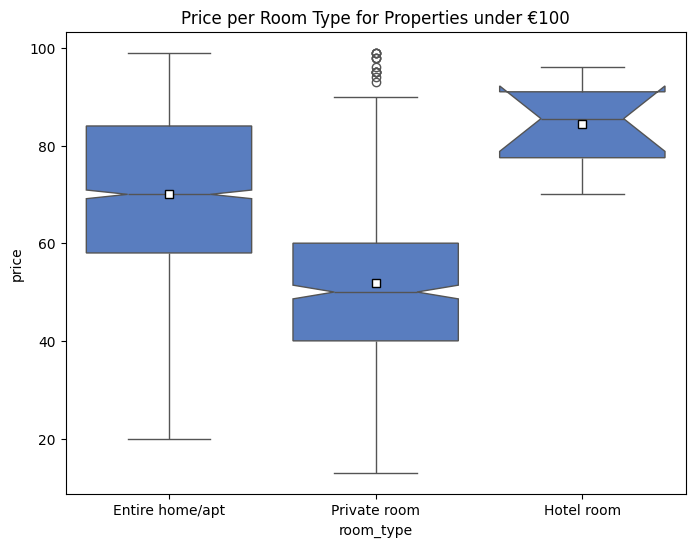

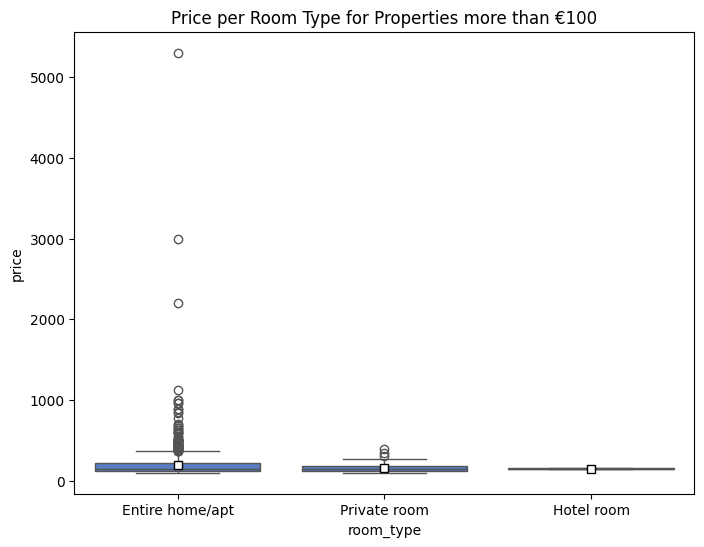

In [ ]:
title = 'Price per Room Type for Properties under €100'
data_filtered = data.loc[data['price'] < 100]
f, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='room_type', y='price', data=data_filtered, notch=True, showmeans=True,
           meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"})
plt.title(title)
plt.ioff()

title = 'Price per Room Type for Properties more than €100'
data_filtered = data.loc[data['price'] > 100]
f, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='room_type', y='price', data=data_filtered, notch=False, showmeans=True,
           meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"})
plt.title(title)
plt.show()

## 3.5 Price relation to the number of review per month

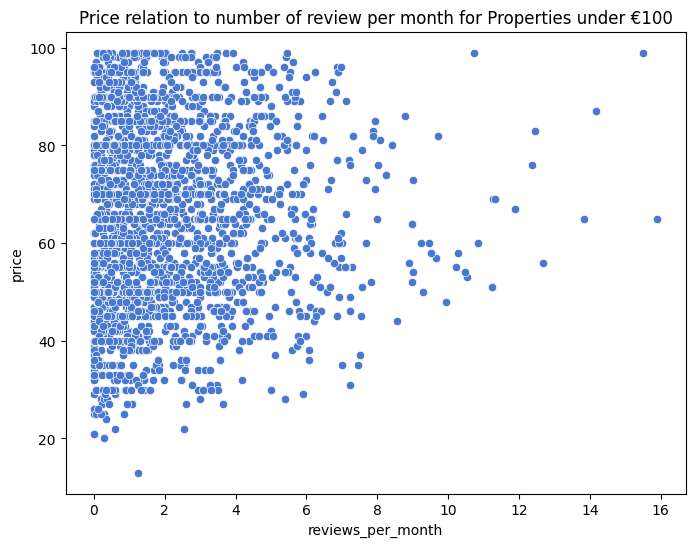

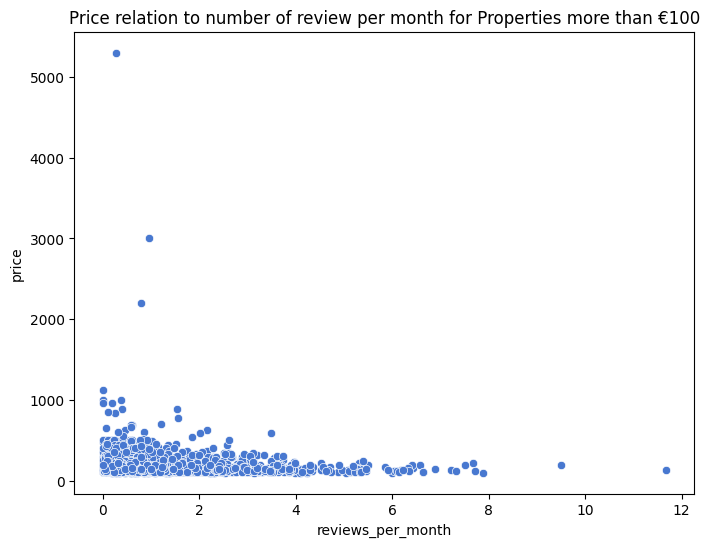

In [ ]:
# see https://seaborn.pydata.org/generated/seaborn.scatterplot.html
sns.set_palette("muted")
x = 'reviews_per_month'
y = 'price'

title = 'Price relation to number of review per month for Properties under €100'
data_filtered = data.loc[(data['price'] < 100) & (data['reviews_per_month'] < 30)]
f, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=x, y=y, data=data_filtered)
plt.title(title)
plt.ioff()

title = 'Price relation to number of review per month for Properties more than €100'
data_filtered = data.loc[data['price'] > 100]
f, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=x, y=y, data=data_filtered)
plt.title(title)
plt.ioff()
sns.set_palette(cbPalette)
plt.show()

##  3.6 Price relation to the number of reviews

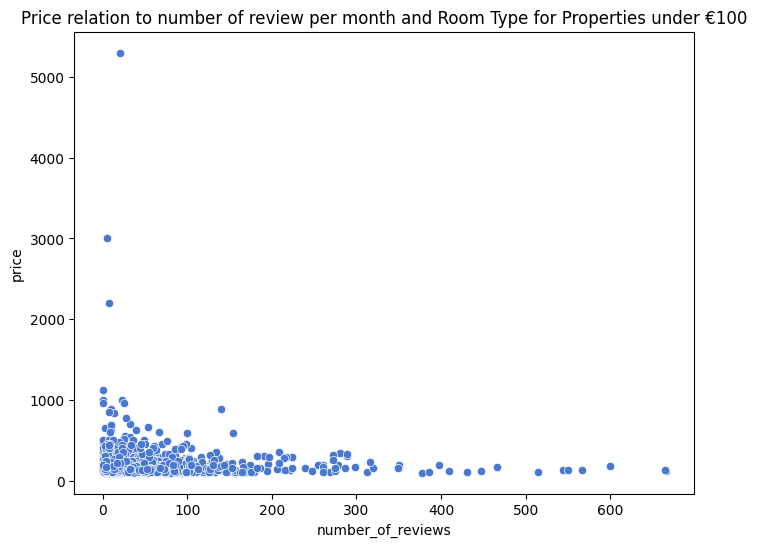

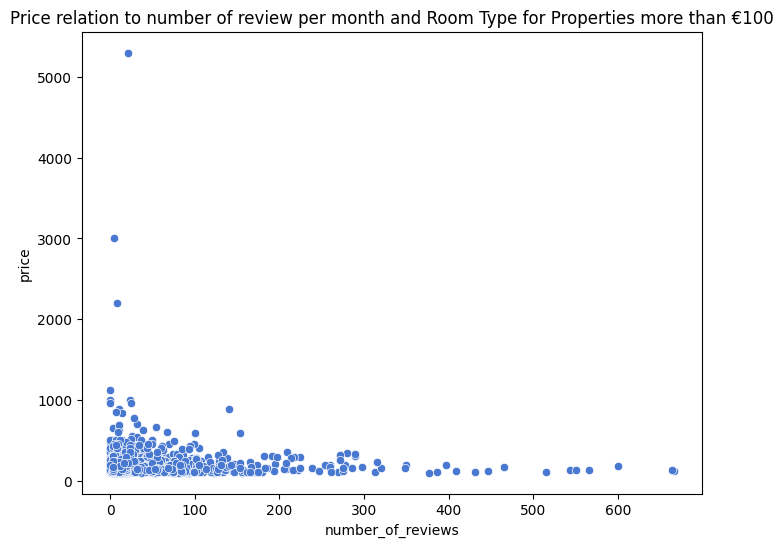

In [ ]:
# see https://seaborn.pydata.org/generated/seaborn.scatterplot.html
sns.set_palette("muted")
x = 'number_of_reviews'
y = 'price'

title = 'Price relation to number of review per month and Room Type for Properties under €100'
data_filtered = data.loc[(data['price'] > 100)]
f, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=x, y=y, data=data_filtered)
plt.title(title)
plt.ioff()

title = 'Price relation to number of review per month and Room Type for Properties more than €100'
data_filtered = data.loc[(data['price'] > 100)]
f, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=x, y=y, data=data_filtered)
plt.title(title)
plt.ioff()
sns.set_palette(cbPalette)
plt.show()

##  3.7 Price relation to minimum_nights

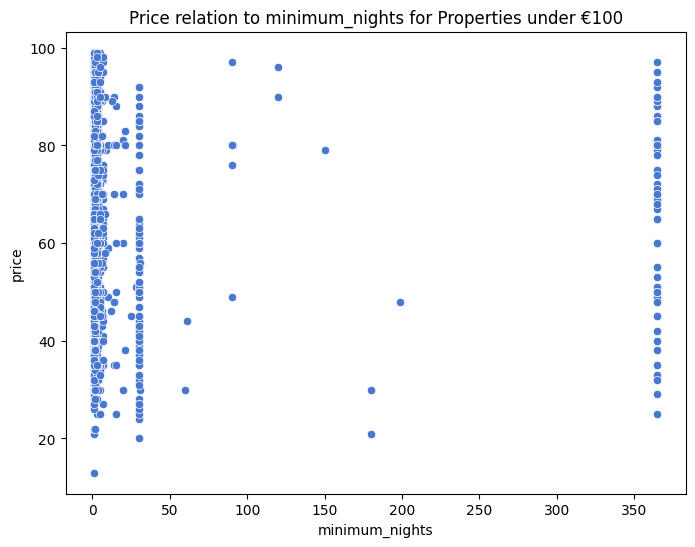

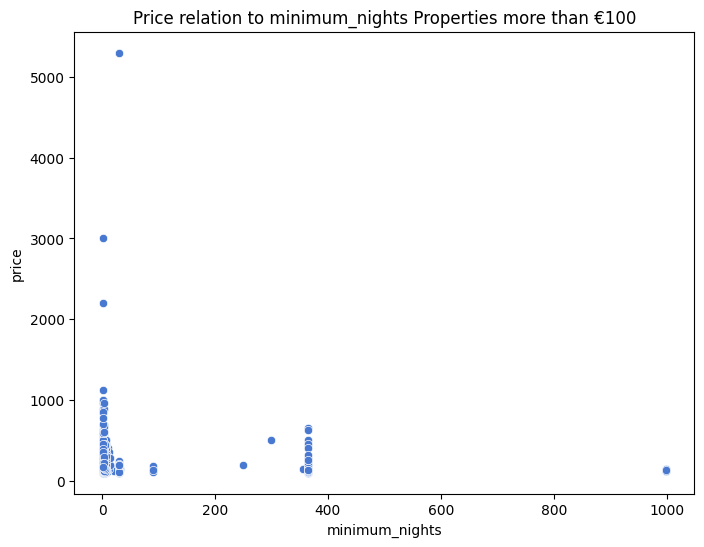

In [ ]:
# see https://seaborn.pydata.org/generated/seaborn.scatterplot.html
sns.set_palette("muted")
x = 'minimum_nights'
y = 'price'

title = 'Price relation to minimum_nights for Properties under €100'
data_filtered = data.loc[data['price'] < 100]
f, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=x, y=y, data=data_filtered)
plt.title(title)
plt.ioff()

title = 'Price relation to minimum_nights Properties more than €100'
data_filtered = data.loc[data['price'] > 100]
f, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=x, y=y, data=data_filtered)
plt.title(title)
plt.ioff()
sns.set_palette(cbPalette)
plt.show()

##  3.8 Price relation to calculated_host_listings_count

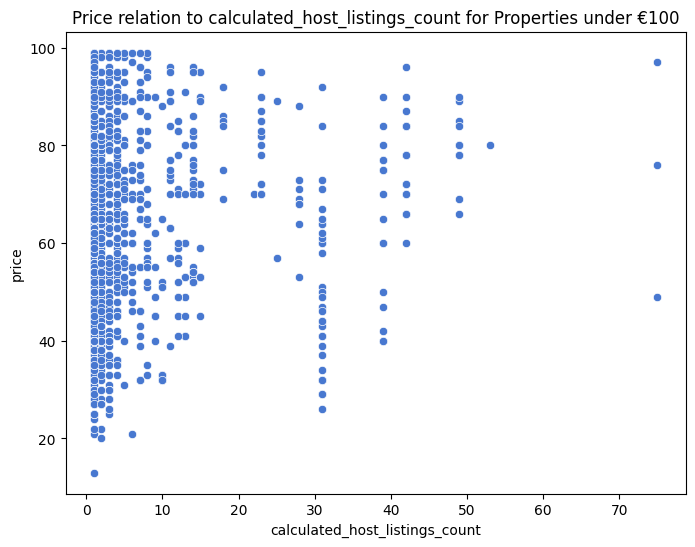

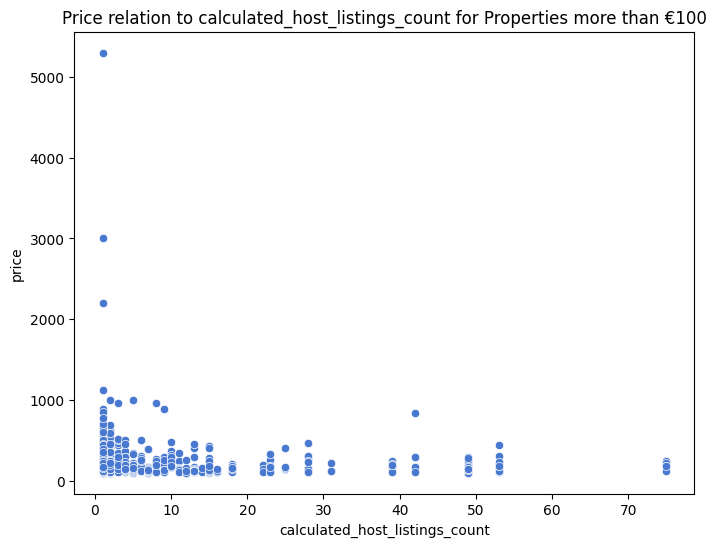

In [ ]:
# see https://seaborn.pydata.org/generated/seaborn.scatterplot.html
sns.set_palette("muted")
x = 'calculated_host_listings_count'
y = 'price'

title = 'Price relation to calculated_host_listings_count for Properties under €100'
data_filtered = data.loc[data['price'] < 100]
f, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=x, y=y, data=data_filtered)
plt.title(title)
plt.ioff()

title = 'Price relation to calculated_host_listings_count for Properties more than €100'
data_filtered = data.loc[data['price'] > 100]
f, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=x, y=y, data=data_filtered)
plt.title(title)
plt.ioff()
sns.set_palette(cbPalette)
plt.show()

##  3.9 Price relation to availability

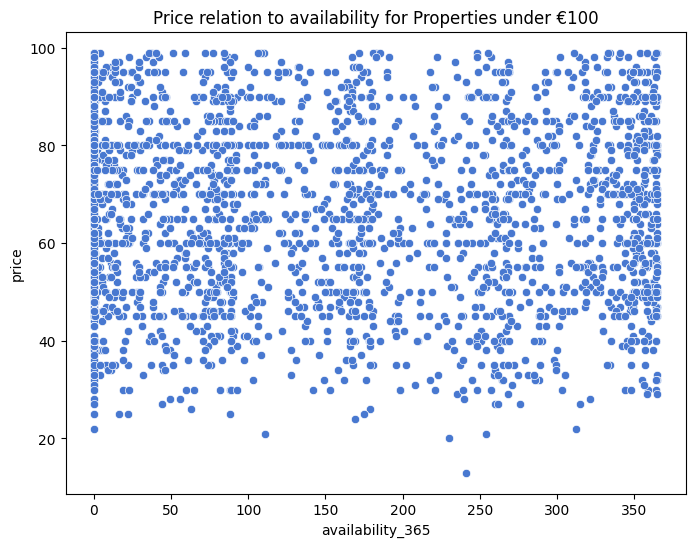

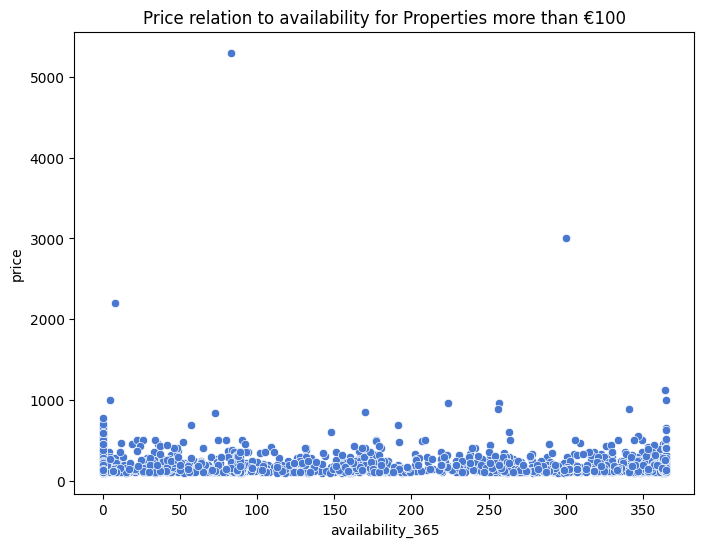

In [ ]:
# see https://seaborn.pydata.org/generated/seaborn.scatterplot.html
sns.set_palette("muted")
x = 'availability_365'
y = 'price'

title = 'Price relation to availability for Properties under €100'
data_filtered = data.loc[data['price'] < 100]
f, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=x, y=y, data=data_filtered)
plt.title(title)
plt.ioff()

title = 'Price relation to availability for Properties more than €100'
data_filtered = data.loc[data['price'] > 100]
f, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=x, y=y, data=data_filtered)
plt.title(title)
plt.ioff()
sns.set_palette(cbPalette)
plt.show()

##  3.10 Price relation to note

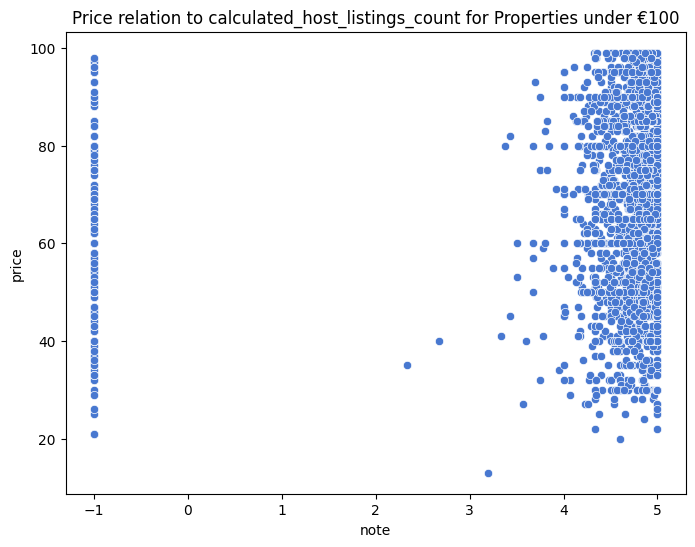

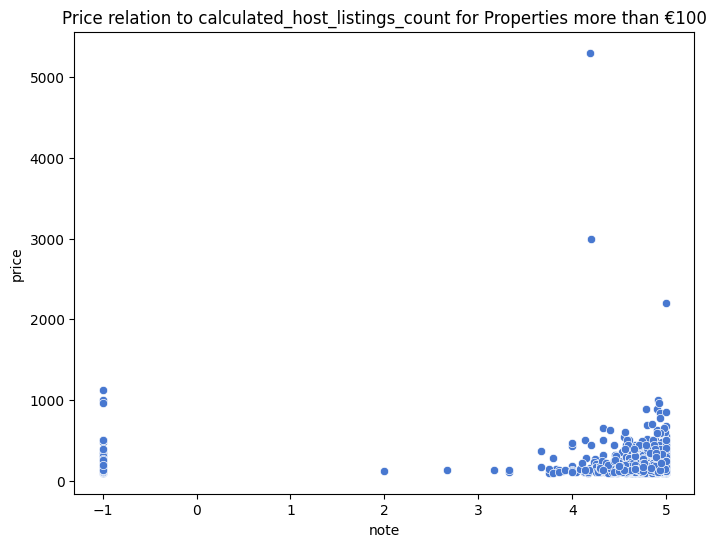

In [ ]:
# see https://seaborn.pydata.org/generated/seaborn.scatterplot.html
sns.set_palette("muted")
x = 'note'
y = 'price'

title = 'Price relation to calculated_host_listings_count for Properties under €100'
data_filtered = data.loc[data['price'] < 100]
f, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=x, y=y, data=data_filtered)
plt.title(title)
plt.ioff()

title = 'Price relation to calculated_host_listings_count for Properties more than €100'
data_filtered = data.loc[data['price'] > 100]
f, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=x, y=y, data=data_filtered)
plt.title(title)
plt.ioff()
sns.set_palette(cbPalette)
plt.show()

##  3.11 Price relation to number_of_bedrooms

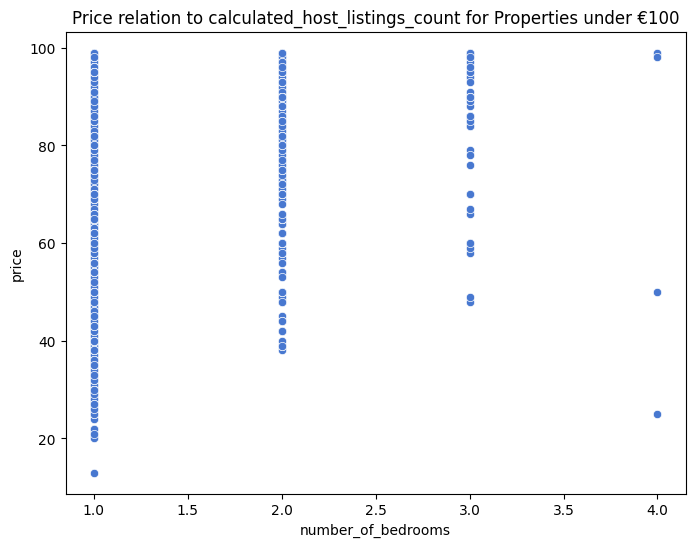

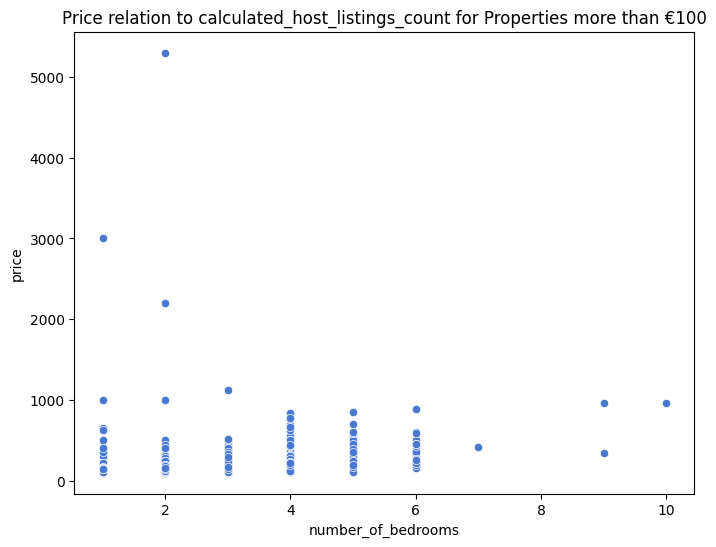

In [ ]:
# see https://seaborn.pydata.org/generated/seaborn.scatterplot.html
sns.set_palette("muted")
x = 'number_of_bedrooms'
y = 'price'

title = 'Price relation to calculated_host_listings_count for Properties under €100'
data_filtered = data.loc[data['price'] < 100]
f, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=x, y=y, data=data_filtered)
plt.title(title)
plt.ioff()

title = 'Price relation to calculated_host_listings_count for Properties more than €100'
data_filtered = data.loc[data['price'] > 100]
f, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=x, y=y, data=data_filtered)
plt.title(title)
plt.ioff()
sns.set_palette(cbPalette)
plt.show()

##  3.12 Price relation to number_of_beds

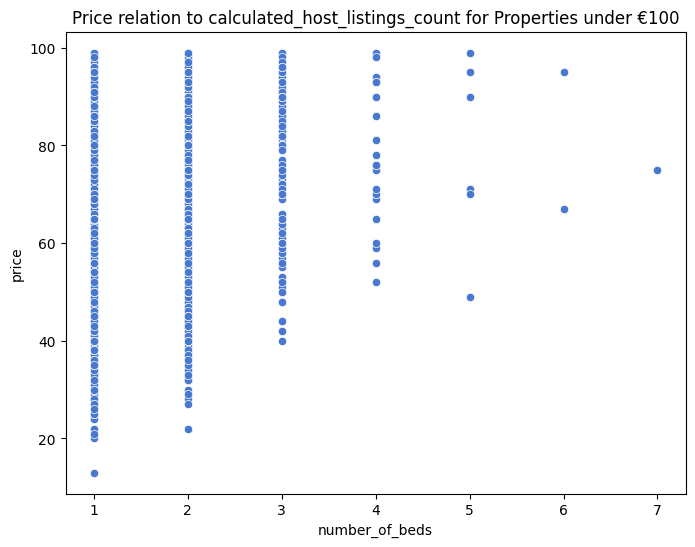

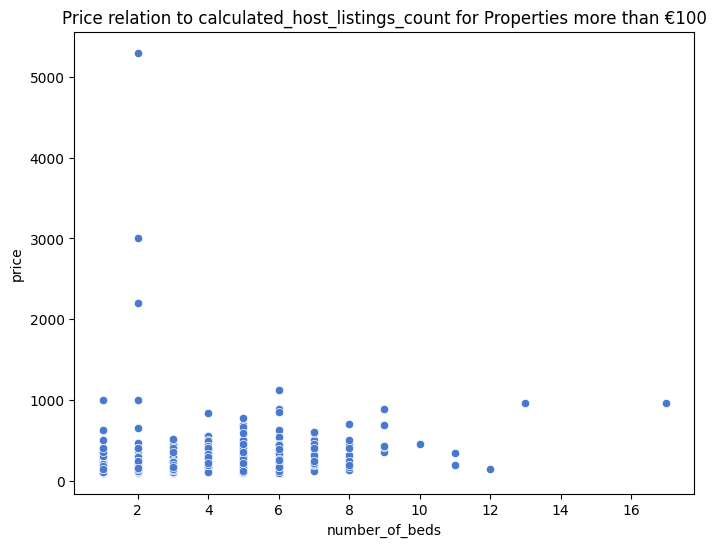

In [ ]:
# see https://seaborn.pydata.org/generated/seaborn.scatterplot.html
sns.set_palette("muted")
x = 'number_of_beds'
y = 'price'

title = 'Price relation to calculated_host_listings_count for Properties under €100'
data_filtered = data.loc[data['price'] < 100]
f, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=x, y=y, data=data_filtered)
plt.title(title)
plt.ioff()

title = 'Price relation to calculated_host_listings_count for Properties more than €100'
data_filtered = data.loc[data['price'] > 100]
f, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=x, y=y, data=data_filtered)
plt.title(title)
plt.ioff()
sns.set_palette(cbPalette)
plt.show()

##  3.13 Price relation to number_of_baths

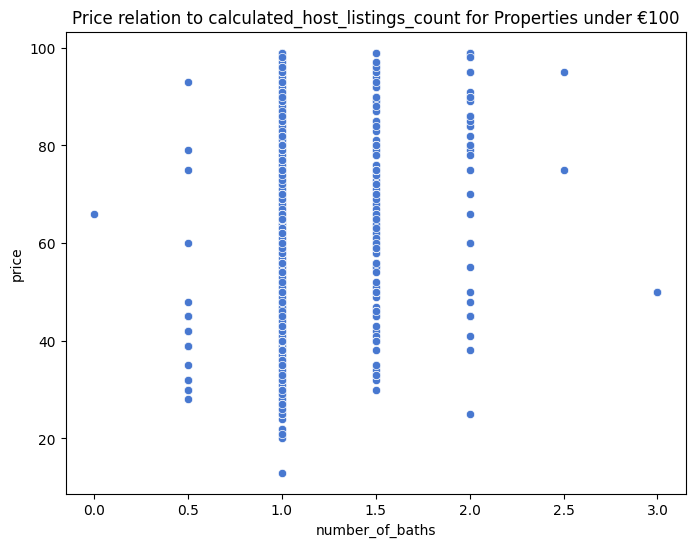

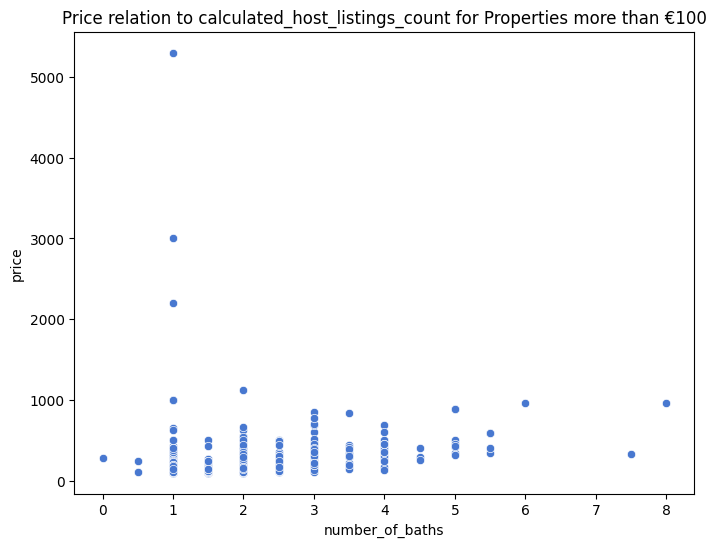

In [ ]:
# see https://seaborn.pydata.org/generated/seaborn.scatterplot.html
sns.set_palette("muted")
x = 'number_of_baths'
y = 'price'

title = 'Price relation to calculated_host_listings_count for Properties under €100'
data_filtered = data.loc[data['price'] < 100]
f, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=x, y=y, data=data_filtered)
plt.title(title)
plt.ioff()

title = 'Price relation to calculated_host_listings_count for Properties more than €100'
data_filtered = data.loc[data['price'] > 100]
f, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=x, y=y, data=data_filtered)
plt.title(title)
plt.ioff()
sns.set_palette(cbPalette)
plt.show()

# 4.Modeling First Model

## 4.1 Data Preprocessing

In [ ]:
data_model1 = data.copy()
#data_model1.drop(['reviews_per_month', 'number_of_beds', 'number_of_baths', 'neighbourhood'], axis=1, inplace=True)
epsilon = 1e-9
data_model1['minimum_nights'] = np.where(data_model1['minimum_nights'] <= 0, epsilon, data_model1['minimum_nights'])
data_model1['number_of_reviews'] = np.where(data_model1['number_of_reviews'] <= 0, epsilon, data_model1['number_of_reviews'])
data_model1['reviews_per_month'] = np.where(data_model1['reviews_per_month'] <= 0, epsilon, data_model1['reviews_per_month'])
data_model1['calculated_host_listings_count'] = np.where(data_model1['calculated_host_listings_count'] <= 0, epsilon, data_model1['calculated_host_listings_count'])
data_model1['availability_365'] = np.where(data_model1['availability_365'] <= 0, epsilon, data_model1['availability_365'])
data_model1['note'] = np.where(data_model1['note'] <= 0, epsilon, data_model1['note'])

# Appliquer la transformation log10
data_model1['minimum_nights'] = np.log10(data_model1['minimum_nights'])
data_model1['number_of_reviews'] = np.log10(data_model1['number_of_reviews'])
data_model1['reviews_per_month'] = np.log10(data_model1['reviews_per_month'])
data_model1['calculated_host_listings_count'] = np.log10(data_model1['calculated_host_listings_count'])
data_model1['availability_365'] = np.log10(data_model1['availability_365'])
data_model1['note'] = np.log10(data_model1['note'])

# Encoding categorical data_model1
data_model1 = pd.get_dummies(data_model1, columns=['room_type'], drop_first=True)
data_model1 = pd.get_dummies(data_model1, columns=['neighbourhood'], drop_first=True)
data_model1 = pd.get_dummies(data_model1, columns=['neighbourhood_group'], drop_first=True)
data_model1 = pd.get_dummies(data_model1, columns=['number_of_bedrooms'], prefix='bedrooms', drop_first=True)
data_model1 = pd.get_dummies(data_model1, columns=['number_of_beds'], prefix='beds', drop_first=True)
data_model1 = pd.get_dummies(data_model1, columns=['number_of_baths'], prefix='baths', drop_first=True)
data_model1 = pd.get_dummies(data_model1, columns=['type_of_baths'], drop_first=True)

In [ ]:
data_filtered_low = data_model1.loc[(data_model1['price'] < 100)]
data_filtered_low.shape

(2630, 24)

In [ ]:
data_filtered_high = data_model1.loc[(data_model1['price'] > 100)]
data_filtered_high.shape

(1629, 24)

## 4.2 Multiple Linear Regression

### 4.2.1 Modeling on lower price dataset

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Assuming data_filtered_high is already defined and preprocessed
X = data_filtered_low.drop('price', axis=1).values
y = data_filtered_low['price'].values
y_log = np.log10(y)  # Log transform the target variable

# Define K-fold cross-validation
kf = KFold(n_splits=8, shuffle=True, random_state=0)

best_r2_test = -np.inf
best_split = None

# Iterate over each split
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_log[train_index], y_log[test_index]

    # Train the model
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    # Predict and calculate the R² score on the test set
    y_pred = lr.predict(X_test)
    r2_test = r2_score(y_test, y_pred)

    # Update the best split and highest R² score
    if r2_test > best_r2_test:
        best_r2_test = r2_test
        best_split = (train_index, test_index)

# Use the best split for the final model training and evaluation
X_train, X_test = X[best_split[0]], X[best_split[1]]
y_train, y_test = y_log[best_split[0]], y_log[best_split[1]]

# Train the model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict and evaluate
y_pred = lr.predict(X_test)
df = pd.DataFrame({'Actual': np.round(10 ** y_test, 0),  # Inverse log transform
                   'Predicted': np.round(10 ** y_pred, 0)})

# Calculate the difference
df['Difference'] = df['Predicted'] - df['Actual']

# Calculate the mean difference
mean_difference = np.mean(df['Difference'])

# Calculate the variance of the difference
variance_difference = np.var(df['Difference'])

# Print the results
print('Best R² score on test set:', best_r2_test)
print('Mean Difference:', mean_difference)
print('Variance of Difference:', variance_difference)

# Use the transformed back to original values for calculating evaluation metrics
y_test_exp = 10 ** y_test
y_pred_test_exp = 10 ** y_pred
y_exp = y  # Original prices data

print('Price mean:', np.round(np.mean(y_exp), 2))
print('Price std:', np.round(np.std(y_exp), 2))
print('RMSE:', np.round(np.sqrt(mean_squared_error(y_test_exp, y_pred_test_exp)), 2))
print('R2 score train:', np.round(r2_score(y_train, lr.predict(X_train)), 2))
print('R2 score test:', np.round(r2_score(y_test_exp, y_pred_test_exp), 2))

Best R² score on test set: 0.4336404684668639
Mean Difference: -2.143292682926829
Variance of Difference: 203.0556867192148
Price mean: 66.69
Price std: 18.08
RMSE: 14.4
R2 score train: 0.35
R2 score test: 0.39


### 4.2.2 Modeling on higher price dataset

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Assuming data_filtered_high is already defined and preprocessed
X = data_filtered_high.drop('price', axis=1).values
y = data_filtered_high['price'].values
y_log = np.log10(y)  # Log transform the target variable

# Define K-fold cross-validation
kf = KFold(n_splits=8, shuffle=True, random_state=0)

best_r2_test = -np.inf
best_split = None

# Iterate over each split
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_log[train_index], y_log[test_index]

    # Train the model
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    # Predict and calculate the R² score on the test set
    y_pred = lr.predict(X_test)
    r2_test = r2_score(y_test, y_pred)

    # Update the best split and highest R² score
    if r2_test > best_r2_test:
        best_r2_test = r2_test
        best_split = (train_index, test_index)

# Use the best split for the final model training and evaluation
X_train, X_test = X[best_split[0]], X[best_split[1]]
y_train, y_test = y_log[best_split[0]], y_log[best_split[1]]

# Train the model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict and evaluate
y_pred = lr.predict(X_test)
df = pd.DataFrame({'Actual': np.round(10 ** y_test, 0),  # Inverse log transform
                   'Predicted': np.round(10 ** y_pred, 0)})

# Calculate the difference
df['Difference'] = df['Predicted'] - df['Actual']

# Calculate the mean difference
mean_difference = np.mean(df['Difference'])

# Calculate the variance of the difference
variance_difference = np.var(df['Difference'])

# Print the results
print('Best R² score on test set:', best_r2_test)
print('Mean Difference:', mean_difference)
print('Variance of Difference:', variance_difference)

# Use the transformed back to original values for calculating evaluation metrics
y_test_exp = 10 ** y_test
y_pred_test_exp = 10 ** y_pred
y_exp = y  # Original prices data

print('Price mean:', np.round(np.mean(y_exp), 2))
print('Price std:', np.round(np.std(y_exp), 2))
print('RMSE:', np.round(np.sqrt(mean_squared_error(y_test_exp, y_pred_test_exp)), 2))
print('R2 score train:', np.round(r2_score(y_train, lr.predict(X_train)), 2))
print('R2 score test:', np.round(r2_score(y_test_exp, y_pred_test_exp), 2))


Best R² score on test set: 0.39791563957190945
Mean Difference: -1.5270935960591132
Variance of Difference: 4966.495571355772
Price mean: 194.5
Price std: 187.39
RMSE: 70.47
R2 score train: 0.36
R2 score test: 0.38


*  Both models of Linear Regression perform not well with R2-score around 0.4

## 4.3 Random Forest Regression

### 4.3.1 Modeling on lower price dataset

In [ ]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Assuming data_filtered_high is already defined and preprocessed
X = data_filtered_low.drop('price', axis=1).values
y = data_filtered_low['price'].values
y_log = np.log10(y)  # Log transform the target variable

# Split data into initial training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.3, random_state=2)

# Set up KFold cross-validation on the training set
kf = KFold(n_splits=10, shuffle=True, random_state=2)

# Define the model
rfr = RandomForestRegressor(max_depth=8, n_estimators=100, random_state=0)

# Placeholder for the best scores and model
best_r2_score = -np.inf
best_X_train, best_X_test, best_y_train, best_y_test = None, None, None, None

# Perform KFold cross-validation on the training set
for train_index, test_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[test_index]

    rfr.fit(X_train_fold, y_train_fold)

    train_r2 = r2_score(y_train_fold, rfr.predict(X_train_fold))
    val_r2 = r2_score(y_val_fold, rfr.predict(X_val_fold))

    # Save the best split based on validation R2 score
    if val_r2 > best_r2_score:
        best_r2_score = val_r2
        best_X_train, best_X_test = X_train_fold, X_val_fold
        best_y_train, best_y_test = y_train_fold, y_val_fold

# Fit the model on the best training set
rfr.fit(best_X_train, best_y_train)

# Predicting the test set results
y_pred_log = rfr.predict(X_test)

# Transform predictions back to the original scale
y_pred = 10**y_pred_log
y_test_original = 10**y_test  # Transform test targets back to the original scale

# Calculate R² score on the test set with original scale
test_r2 = r2_score(y_test_original, y_pred)

# Create a DataFrame to hold actual and predicted values for the test set
df = pd.DataFrame({'Actual': y_test_original, 'Predicted': y_pred})
df['Difference'] = df['Predicted'] - df['Actual']

# Display the first 10 rows
print(df.head(10))

   Actual  Predicted  Difference
0    56.0  57.284635    1.284635
1    60.0  71.036681   11.036681
2    91.0  78.968382  -12.031618
3    50.0  76.358168   26.358168
4    65.0  49.609877  -15.390123
5    60.0  65.208636    5.208636
6    50.0  50.910575    0.910575
7    90.0  69.003248  -20.996752
8    45.0  61.430837   16.430837
9    90.0  64.314236  -25.685764


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn import metrics
# Calculate the mean and variance of the difference
mean_difference = np.mean(df['Difference'])
variance_difference = np.var(df['Difference'])
from sklearn.metrics import r2_score
# Print the evaluation metrics
print(f"Mean Difference: {mean_difference}")
print(f"Variance of Difference: {variance_difference}")
print(f"Price mean: {np.round(np.mean(y), 2)}")
print(f"Price std: {np.round(np.std(y), 2)}")
print(f"RMSE: {np.round(np.sqrt(mean_squared_error(best_y_test, rfr.predict(best_X_test))), 2)}")
print(f"R² score train: {np.round(r2_score(best_y_train, rfr.predict(best_X_train)), 2)}")
print(f"R² score test: {np.round(r2_score(best_y_test, rfr.predict(best_X_test)), 2)}")

Mean Difference: -2.0712799447966455
Variance of Difference: 211.8341731316679
Price mean: 66.69
Price std: 18.08
RMSE: 0.09
R² score train: 0.68
R² score test: 0.52


### 4.3.2 Modeling on higher price dataset

In [ ]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.utils import shuffle

# Assuming data_filtered_high is already defined and preprocessed
X = data_filtered_high.drop('price', axis=1).values
y = data_filtered_high['price'].values
y_log = np.log10(y)  # Log transform the target variable

# Split data into initial training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.3, random_state=0)

# Set up KFold cross-validation on the training set
kf = KFold(n_splits=10, shuffle=True, random_state=0)

# Define the model
rfr = RandomForestRegressor(max_depth=8, n_estimators=100, random_state=0)

# Placeholder for the best scores and model
best_r2_score = -np.inf
best_X_train, best_X_test, best_y_train, best_y_test = None, None, None, None

# Perform KFold cross-validation on the training set
for train_index, test_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[test_index]

    rfr.fit(X_train_fold, y_train_fold)

    train_r2 = r2_score(y_train_fold, rfr.predict(X_train_fold))
    val_r2 = r2_score(y_val_fold, rfr.predict(X_val_fold))

    # Save the best split based on validation R2 score
    if val_r2 > best_r2_score:
        best_r2_score = val_r2
        best_X_train, best_X_test = X_train_fold, X_val_fold
        best_y_train, best_y_test = y_train_fold, y_val_fold

# Fit the model on the best training set
rfr.fit(best_X_train, best_y_train)

# Predicting the test set results
y_pred_log = rfr.predict(X_test)

# Transform predictions back to the original scale
y_pred = 10**y_pred_log
y_test_original = 10**y_test  # Transform test targets back to the original scale

# Calculate R² score on the test set with original scale
test_r2 = r2_score(y_test_original, y_pred)

# Create a DataFrame to hold actual and predicted values for the test set
df = pd.DataFrame({'Actual': y_test_original, 'Predicted': y_pred})
df['Difference'] = df['Predicted'] - df['Actual']

# Display the first 10 rows
print(df.head(10))

   Actual   Predicted  Difference
0   110.0  141.372000   31.372000
1   116.0  139.793228   23.793228
2   200.0  170.220090  -29.779910
3   399.0  203.536703 -195.463297
4   170.0  132.566223  -37.433777
5   105.0  130.685168   25.685168
6   140.0  198.343328   58.343328
7   128.0  132.898606    4.898606
8   200.0  201.574241    1.574241
9   280.0  208.044671  -71.955329


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn import metrics
# Calculate the mean and variance of the difference
mean_difference = np.mean(df['Difference'])
variance_difference = np.var(df['Difference'])
from sklearn.metrics import r2_score
# Print the evaluation metrics
print(f"Mean Difference: {mean_difference}")
print(f"Variance of Difference: {variance_difference}")
print(f"Price mean: {np.round(np.mean(y), 2)}")
print(f"Price std: {np.round(np.std(y), 2)}")
print(f"RMSE: {np.round(np.sqrt(mean_squared_error(best_y_test, rfr.predict(best_X_test))), 2)}")
print(f"R² score train: {np.round(r2_score(best_y_train, rfr.predict(best_X_train)), 2)}")
print(f"R² score test: {np.round(r2_score(best_y_test, rfr.predict(best_X_test)), 2)}")

Mean Difference: -23.003383138788934
Variance of Difference: 12335.379032745732
Price mean: 194.5
Price std: 187.39
RMSE: 0.13
R² score train: 0.64
R² score test: 0.55


*  R2 score of train set and test set have huge difference, might encounter the problem of overfitting, need to tune the parametre.

## 4.4 Ridge Regression

### 4.4.1 Modeling on lower price dataset




In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Split the dataset
X = data_filtered_low.drop('price', axis=1).values
y = data_filtered_low['price'].values
y = np.log10(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Define parameter grid
param_grid_ridge = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}

# Initialize Ridge regression model
ridge = Ridge()

# Define K-fold cross-validation
kf = KFold(n_splits=8, shuffle=True, random_state=0)

# Grid search for hyperparameter tuning
ridge_grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid_ridge, cv=kf, scoring='neg_mean_squared_error')
ridge_grid_search.fit(X, y)

# Best parameters
print("Best parameters for Ridge regression:", ridge_grid_search.best_params_)

# Best CV RMSE score
ridge_best_rmse = np.sqrt(-ridge_grid_search.best_score_)
print("Best CV RMSE for Ridge regression:", ridge_best_rmse)

# Train Ridge regression model with best parameters
ridge_best = Ridge(alpha=ridge_grid_search.best_params_['alpha'])
ridge_best.fit(X_train, y_train)
y_pred_ridge = ridge_best.predict(X_test)

# Evaluate Ridge regression model
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
ridge_r2_train = r2_score(y_train, ridge_best.predict(X_train))
ridge_r2_test = r2_score(y_test, y_pred_ridge)

# Print evaluation metrics
print('Ridge Regression:')
print('RMSE:', np.round(ridge_rmse, 2))
print('R2 score train:', np.round(ridge_r2_train, 2))
print('R2 score test:', np.round(ridge_r2_test, 2))

# Create DataFrame for actual vs predicted comparison
df_ridge = pd.DataFrame({'Actual': np.round(10 ** y_test, 0),
                         'Predicted': np.round(10 ** y_pred_ridge, 0)})
df_ridge['Difference'] = df_ridge['Predicted'] - df_ridge['Actual']

# Display first 10 results
print('Ridge Regression Predictions:')
print(df_ridge.head(10))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.67455e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.7107e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.67855e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.70646e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning

Best parameters for Ridge regression: {'alpha': 0.1}
Best CV RMSE for Ridge regression: 0.10473683421599288
Ridge Regression:
RMSE: 0.1
R2 score train: 0.37
R2 score test: 0.32
Ridge Regression Predictions:
   Actual  Predicted  Difference
0    73.0       70.0        -3.0
1    86.0       74.0       -12.0
2    77.0       71.0        -6.0
3    90.0       73.0       -17.0
4    50.0       57.0         7.0
5    69.0       56.0       -13.0
6    61.0       73.0        12.0
7    80.0       49.0       -31.0
8    95.0       92.0        -3.0
9    69.0       61.0        -8.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.54555e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.52972e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.54434e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.50923e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarnin

### 4.4.2 Modeling on higher price dataset




In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Split the dataset
X = data_filtered_high.drop('price', axis=1).values
y = data_filtered_high['price'].values
y = np.log10(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Define parameter grid
param_grid_ridge = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}

# Initialize Ridge regression model
ridge = Ridge()

# Define K-fold cross-validation
kf = KFold(n_splits=8, shuffle=True, random_state=0)

# Grid search for hyperparameter tuning
ridge_grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid_ridge, cv=kf, scoring='neg_mean_squared_error')
ridge_grid_search.fit(X, y)

# Best parameters
print("Best parameters for Ridge regression:", ridge_grid_search.best_params_)

# Best CV RMSE score
ridge_best_rmse = np.sqrt(-ridge_grid_search.best_score_)
print("Best CV RMSE for Ridge regression:", ridge_best_rmse)

# Train Ridge regression model with best parameters
ridge_best = Ridge(alpha=ridge_grid_search.best_params_['alpha'])
ridge_best.fit(X_train, y_train)
y_pred_ridge = ridge_best.predict(X_test)

# Evaluate Ridge regression model
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
ridge_r2_train = r2_score(y_train, ridge_best.predict(X_train))
ridge_r2_test = r2_score(y_test, y_pred_ridge)

# Print evaluation metrics
print('Ridge Regression:')
print('RMSE:', np.round(ridge_rmse, 2))
print('R2 score train:', np.round(ridge_r2_train, 2))
print('R2 score test:', np.round(ridge_r2_test, 2))

# Create DataFrame for actual vs predicted comparison
df_ridge = pd.DataFrame({'Actual': np.round(10 ** y_test, 0),
                         'Predicted': np.round(10 ** y_pred_ridge, 0)})
df_ridge['Difference'] = df_ridge['Predicted'] - df_ridge['Actual']

# Display first 10 results
print('Ridge Regression Predictions:')
print(df_ridge.head(10))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.7302e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.7354e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.52245e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.73378e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning:

Best parameters for Ridge regression: {'alpha': 0.1}
Best CV RMSE for Ridge regression: 0.15753538255241198
Ridge Regression:
RMSE: 0.16
R2 score train: 0.36
R2 score test: 0.33
Ridge Regression Predictions:
   Actual  Predicted  Difference
0   110.0      144.0        34.0
1   116.0      139.0        23.0
2   200.0      177.0       -23.0
3   399.0      202.0      -197.0
4   170.0      129.0       -41.0
5   105.0      125.0        20.0
6   140.0      217.0        77.0
7   128.0      133.0         5.0
8   200.0      180.0       -20.0
9   280.0      213.0       -67.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.49283e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.56749e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.48912e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.48515e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarnin

## 4.5 Lasso Regression

### 4.5.1 Modeling on lower price dataset




In [ ]:
from sklearn.linear_model import Lasso

# Split the dataset
X = data_filtered_low.drop('price', axis=1).values
y = data_filtered_low['price'].values
y = np.log10(y)

# Define parameter grid
param_grid_lasso = {
    'alpha': [1e-4, 5e-3, 1e-3, 5e-2, 1e-2, 0.1]
}

# Initialize Lasso regression model
lasso = Lasso()

# Grid search for hyperparameter tuning
lasso_grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid_lasso, cv=kf, scoring='neg_mean_squared_error')
lasso_grid_search.fit(X, y)

# Best parameters
print("Best parameters for Lasso regression:", lasso_grid_search.best_params_)

# Best CV RMSE score
lasso_best_rmse = np.sqrt(-lasso_grid_search.best_score_)
print("Best CV RMSE for Lasso regression:", lasso_best_rmse)

# Train Lasso regression model with best parameters
lasso_best = Lasso(alpha=lasso_grid_search.best_params_['alpha'])
lasso_best.fit(X_train, y_train)
y_pred_lasso = lasso_best.predict(X_test)

# Evaluate Lasso regression model
lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
lasso_r2_train = r2_score(y_train, lasso_best.predict(X_train))
lasso_r2_test = r2_score(y_test, y_pred_lasso)

# Print evaluation metrics
print('Lasso Regression:')
print('RMSE:', np.round(lasso_rmse, 2))
print('R2 score train:', np.round(lasso_r2_train, 2))
print('R2 score test:', np.round(lasso_r2_test, 2))

# Create DataFrame for actual vs predicted comparison
df_lasso = pd.DataFrame({'Actual': np.round(10 ** y_test, 0),
                         'Predicted': np.round(10 ** y_pred_lasso, 0)})
df_lasso['Difference'] = df_lasso['Predicted'] - df_lasso['Actual']

# Display first 10 results
print('Lasso Regression Predictions:')
print(df_lasso.head(10))

Best parameters for Lasso regression: {'alpha': 0.0001}
Best CV RMSE for Lasso regression: 0.1049297913237226
Lasso Regression:
RMSE: 0.16
R2 score train: 0.36
R2 score test: 0.33
Lasso Regression Predictions:
   Actual  Predicted  Difference
0   110.0      144.0        34.0
1   116.0      139.0        23.0
2   200.0      175.0       -25.0
3   399.0      201.0      -198.0
4   170.0      130.0       -40.0
5   105.0      127.0        22.0
6   140.0      214.0        74.0
7   128.0      133.0         5.0
8   200.0      177.0       -23.0
9   280.0      212.0       -68.0


### 4.5.2 Modeling on higher price dataset




In [ ]:
from sklearn.linear_model import Lasso

# Split the dataset
X = data_filtered_high.drop('price', axis=1).values
y = data_filtered_high['price'].values
y = np.log10(y)

# Define parameter grid
param_grid_lasso = {
    'alpha': [1e-4, 5e-3, 1e-3, 5e-2, 1e-2, 0.1]
}

# Initialize Lasso regression model
lasso = Lasso()

# Grid search for hyperparameter tuning
lasso_grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid_lasso, cv=kf, scoring='neg_mean_squared_error')
lasso_grid_search.fit(X, y)

# Best parameters
print("Best parameters for Lasso regression:", lasso_grid_search.best_params_)

# Best CV RMSE score
lasso_best_rmse = np.sqrt(-lasso_grid_search.best_score_)
print("Best CV RMSE for Lasso regression:", lasso_best_rmse)

# Train Lasso regression model with best parameters
lasso_best = Lasso(alpha=lasso_grid_search.best_params_['alpha'])
lasso_best.fit(X_train, y_train)
y_pred_lasso = lasso_best.predict(X_test)

# Evaluate Lasso regression model
lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
lasso_r2_train = r2_score(y_train, lasso_best.predict(X_train))
lasso_r2_test = r2_score(y_test, y_pred_lasso)

# Print evaluation metrics
print('Lasso Regression:')
print('RMSE:', np.round(lasso_rmse, 2))
print('R2 score train:', np.round(lasso_r2_train, 2))
print('R2 score test:', np.round(lasso_r2_test, 2))

# Create DataFrame for actual vs predicted comparison
df_lasso = pd.DataFrame({'Actual': np.round(10 ** y_test, 0),
                         'Predicted': np.round(10 ** y_pred_lasso, 0)})
df_lasso['Difference'] = df_lasso['Predicted'] - df_lasso['Actual']

# Display first 10 results
print('Lasso Regression Predictions:')
print(df_lasso.head(10))

Best parameters for Lasso regression: {'alpha': 0.0001}
Best CV RMSE for Lasso regression: 0.15778395288630806
Lasso Regression:
RMSE: 0.16
R2 score train: 0.36
R2 score test: 0.33
Lasso Regression Predictions:
   Actual  Predicted  Difference
0   110.0      144.0        34.0
1   116.0      139.0        23.0
2   200.0      175.0       -25.0
3   399.0      201.0      -198.0
4   170.0      130.0       -40.0
5   105.0      127.0        22.0
6   140.0      214.0        74.0
7   128.0      133.0         5.0
8   200.0      177.0       -23.0
9   280.0      212.0       -68.0


# 5.Modeling Second Model

## 5.1 Data Preprocessing

In [ ]:
# Recode data as categorical based on quantiles and specified bins
data_encoded = data.copy()

# Recode 'minimum_nights' into two categories
data_encoded['minimum_nights'] = pd.qcut(data['minimum_nights'], q=2, labels=["minimum_nights_low", "minimum_nights_high"])

# Recode 'number_of_reviews' into three categories
data_encoded['number_of_reviews'] = pd.qcut(data['number_of_reviews'], q=3, labels=["number_of_reviews_low", "number_of_reviews_medium", "number_of_reviews_high"])

# Recode 'reviews_per_month' into two categories
data_encoded['reviews_per_month'] = pd.qcut(data['reviews_per_month'], q=2, labels=["reviews_per_month_low", "reviews_per_month_high"])

# Recode 'calculated_host_listings_count' into specified bins
data_encoded['calculated_host_listings_count'] = pd.cut(data['calculated_host_listings_count'],
                                                        bins=[0, 2, data['calculated_host_listings_count'].max()],
                                                        labels=["calculated_host_listings_count_low", "calculated_host_listings_count_high"])

# Recode 'availability_365' into two categories
data_encoded['availability_365'] = pd.qcut(data['availability_365'], q=2, labels=["availability_low", "availability_high"])

# Handle unique bin edges for 'number_of_bedrooms' by dropping duplicates
try:
    data_encoded['number_of_bedrooms'] = pd.qcut(data['number_of_bedrooms'], q=2, labels=["number_of_bedrooms_low", "number_of_bedrooms_high"], duplicates='drop')
except ValueError:
    data_encoded['number_of_bedrooms'] = pd.cut(data['number_of_bedrooms'], bins=2, labels=["number_of_bedrooms_low", "number_of_bedrooms_high"])

# Recode 'number_of_beds' into two categories, handling duplicates
try:
    data_encoded['number_of_beds'] = pd.qcut(data['number_of_beds'], q=2, labels=["number_of_beds_low", "number_of_beds_high"], duplicates='drop')
except ValueError:
    data_encoded['number_of_beds'] = pd.cut(data['number_of_beds'], bins=2, labels=["number_of_beds_low", "number_of_beds_high"])

# Recode 'number_of_baths' into two categories, handling duplicates
try:
    data_encoded['number_of_baths'] = pd.qcut(data['number_of_baths'], q=2, labels=["number_of_baths_low", "number_of_baths_high"], duplicates='drop')
except ValueError:
    data_encoded['number_of_baths'] = pd.cut(data['number_of_baths'], bins=2, labels=["number_of_baths_low", "number_of_baths_high"])

# Display the first few rows of the encoded data
data_encoded.head()


note      number_of_bedrooms       number_of_beds       number_of_baths  \
2  -1.0  number_of_bedrooms_low   number_of_beds_low   number_of_baths_low   
3  -1.0  number_of_bedrooms_low   number_of_beds_low   number_of_baths_low   
5  -1.0  number_of_bedrooms_low   number_of_beds_low   number_of_baths_low   
6  -1.0  number_of_bedrooms_low   number_of_beds_low   number_of_baths_low   
8  -1.0  number_of_bedrooms_low  number_of_beds_high  number_of_baths_high   

  type_of_baths    host_id neighbourhood_group  \
2       private  550336355            Bordeaux   
3       private  549947476             Talence   
5       private  549875028            Bordeaux   
6       private  549874399             Talence   
8       private  548984748              Pessac   

                            neighbourhood   latitude  longitude  \
2  Chartrons - Grand Parc - Jardin Public  44.850702  -0.571528   
3                                 Talence  44.815874  -0.602802   
5                            Bordeaux Sud  44.829162  -0.573464   
6                                 Talence  44.815934  -0.578647   
8                                     Nos  44.813680  -0.635990   

         room_type  price      minimum_nights      number_of_reviews  \
2  Entire home/apt  120.0  minimum_nights_low  number_of_reviews_low   
3  Entire home/apt   50.0  minimum_nights_low  number_of_reviews_low   
5  Entire home/apt  129.0  minimum_nights_low  number_of_reviews_low   
6  Entire home/apt   47.0  minimum_nights_low  number_of_reviews_low   
8  Entire home/apt  139.0  minimum_nights_low  number_of_reviews_low   

       reviews_per_month      calculated_host_listings_count  \
2  reviews_per_month_low  calculated_host_listings_count_low   
3  reviews_per_month_low  calculated_host_listings_count_low   
5  reviews_per_month_low  calculated_host_listings_count_low   
6  reviews_per_month_low  calculated_host_listings_count_low   
8  reviews_per_month_low  calculated_host_listings_count_low   

    availability_365  number_of_reviews_ltm  
2  availability_high                      0  
3  availability_high                      0  
5   availability_low                      0  
6  availability_high                      0  
8  availability_high                      0

In [ ]:
# Encoding categorical data
data_encoded = pd.get_dummies(data_encoded, columns=['neighbourhood_group'], drop_first=True)
data_encoded = pd.get_dummies(data_encoded, columns=['neighbourhood'], drop_first=True)
data_encoded = pd.get_dummies(data_encoded, columns=['room_type'], drop_first=True)
data_encoded = pd.get_dummies(data_encoded, columns=['minimum_nights'], drop_first=True)
data_encoded = pd.get_dummies(data_encoded, columns=['number_of_reviews'], drop_first=True)
data_encoded = pd.get_dummies(data_encoded, columns=['reviews_per_month'], drop_first=True)
data_encoded = pd.get_dummies(data_encoded, columns=['calculated_host_listings_count'], drop_first=True)
data_encoded = pd.get_dummies(data_encoded, columns=['availability_365'], drop_first=True)
data_encoded = pd.get_dummies(data_encoded, columns=['number_of_bedrooms'], drop_first=True)
data_encoded = pd.get_dummies(data_encoded, columns=['number_of_beds'], drop_first=True)
data_encoded = pd.get_dummies(data_encoded, columns=['number_of_baths'], drop_first=True)
data_encoded = pd.get_dummies(data_encoded, columns=['type_of_baths'], drop_first=True)
data_encoded.head()

note    host_id   latitude  longitude  price  number_of_reviews_ltm  \
2  -1.0  550336355  44.850702  -0.571528  120.0                      0   
3  -1.0  549947476  44.815874  -0.602802   50.0                      0   
5  -1.0  549875028  44.829162  -0.573464  129.0                      0   
6  -1.0  549874399  44.815934  -0.578647   47.0                      0   
8  -1.0  548984748  44.813680  -0.635990  139.0                      0   

   neighbourhood_group_Bordeaux  neighbourhood_group_Merignac  \
2                          True                         False   
3                         False                         False   
5                          True                         False   
6                         False                         False   
8                         False                         False   

   neighbourhood_group_Pessac  neighbourhood_group_Talence  ...  \
2                       False                        False  ...   
3                       False                         True  ...   
5                       False                        False  ...   
6                       False                         True  ...   
8                        True                        False  ...   

   room_type_Private room  minimum_nights_minimum_nights_high  \
2                   False                               False   
3                   False                               False   
5                   False                               False   
6                   False                               False   
8                   False                               False   

   number_of_reviews_number_of_reviews_medium  \
2                                       False   
3                                       False   
5                                       False   
6                                       False   
8                                       False   

   number_of_reviews_number_of_reviews_high  \
2                                     False   
3                                     False   
5                                     False   
6                                     False   
8                                     False   

   reviews_per_month_reviews_per_month_high  \
2                                     False   
3                                     False   
5                                     False   
6                                     False   
8                                     False   

   calculated_host_listings_count_calculated_host_listings_count_high  \
2                                              False                    
3                                              False                    
5                                              False                    
6                                              False                    
8                                              False                    

   availability_365_availability_high  \
2                                True   
3                                True   
5                               False   
6                                True   
8                                True   

   number_of_bedrooms_number_of_bedrooms_high  \
2                                       False   
3                                       False   
5                                       False   
6                                       False   
8                                       False   

   number_of_beds_number_of_beds_high  number_of_baths_number_of_baths_high  
2                               False                                 False  
3                               False                                 False  
5                               False                                 False  
6                               False                                 False  
8                                True                                  True  

[5 rows x 57 columns]

In [ ]:
data_filtered_low = data_encoded.loc[(data['price'] < 100)]
data_filtered_low.shape

(2630, 57)

In [ ]:
data_filtered_high = data_encoded.loc[(data['price'] > 100)]
data_filtered_high.shape

(1629, 57)

## 5.2 Multiple Linear Regression

### 5.2.1 Modeling on lower price dataset

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Extract features and target variable
X = data_filtered_low.drop('price', axis=1).values
y = data_filtered_low['price'].values
y = np.log10(y)

# Define K-fold cross-validation
kf = KFold(n_splits=8, shuffle=True, random_state=0)

# Perform K-fold cross-validation
lr = LinearRegression()
cv_results = cross_val_score(lr, X, y, cv=kf, scoring='neg_mean_squared_error')

# Calculate cross-validated root mean squared error
rmse_scores = np.sqrt(-cv_results)

print("Cross-validated RMSE scores:", rmse_scores)
print("Mean RMSE:", np.mean(rmse_scores))
print("Standard Deviation of RMSE:", np.std(rmse_scores), '\n')

# Train and evaluate the model using the entire dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
lr.fit(X_train, y_train)

# Predict and evaluate
y_pred = lr.predict(X_test)
df = pd.DataFrame({'Actual': np.round(10 ** y_test, 0),
                   'Predicted': np.round(10 ** y_pred, 0)})

# Calculate the difference
df['Difference'] = df['Predicted'] - df['Actual']

# Calculate the mean difference
mean_difference = np.mean(df['Difference'])

# Calculate the variance of the difference
variance_difference = np.var(df['Difference'])

# Print the results
print('Mean Difference:', mean_difference)
print('Variance of Difference:', variance_difference)

# Use the transformed back to original values for calculating evaluation metrics
y_test_exp = y_test
y_pred_test_exp = y_pred
y_exp = y  # Original prices data

print('Price mean:', np.round(np.mean(y_exp), 2))
print('Price std:', np.round(np.std(y_exp), 2))
print('RMSE:', np.round(np.sqrt(mean_squared_error(y_test_exp, y_pred_test_exp)), 2))
print('R2 score train:', np.round(r2_score(y_train, lr.predict(X_train)), 2))
print('R2 score test:', np.round(r2_score(y_test_exp, y_pred_test_exp), 2))

df.head(10)

Cross-validated RMSE scores: [0.10786856 0.11168731 0.10081029 0.11670076 0.10389485 0.10627198
 0.10012144 0.1214082 ]
Mean RMSE: 0.10859542315514314
Standard Deviation of RMSE: 0.007069852255752278 

Mean Difference: -2.774397972116603
Variance of Difference: 244.08852070853837
Price mean: 1.81
Price std: 0.13
RMSE: 0.11
R2 score train: 0.34
R2 score test: 0.25


Actual  Predicted  Difference
0    73.0       68.0        -5.0
1    86.0       95.0         9.0
2    77.0       68.0        -9.0
3    90.0       81.0        -9.0
4    50.0       74.0        24.0
5    69.0       57.0       -12.0
6    61.0       65.0         4.0
7    80.0       49.0       -31.0
8    95.0       74.0       -21.0
9    69.0       62.0        -7.0

### 5.2.2 Modeling on higher price dataset

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Extract features and target variable
X = data_filtered_high.drop('price', axis=1).values
y = data_filtered_high['price'].values
y = np.log10(y)

# Define K-fold cross-validation
kf = KFold(n_splits=8, shuffle=True, random_state=0)

# Perform K-fold cross-validation
lr = LinearRegression()
cv_results = cross_val_score(lr, X, y, cv=kf, scoring='neg_mean_squared_error')

# Calculate cross-validated root mean squared error
rmse_scores = np.sqrt(-cv_results)

print("Cross-validated RMSE scores:", rmse_scores)
print("Mean RMSE:", np.mean(rmse_scores))
print("Standard Deviation of RMSE:", np.std(rmse_scores), '\n')

# Train and evaluate the model using the entire dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
lr.fit(X_train, y_train)

# Predict and evaluate
y_pred = lr.predict(X_test)
df = pd.DataFrame({'Actual': np.round(10 ** y_test, 0),
                   'Predicted': np.round(10 ** y_pred, 0)})

# Calculate the difference
df['Difference'] = df['Predicted'] - df['Actual']

# Calculate the mean difference
mean_difference = np.mean(df['Difference'])

# Calculate the variance of the difference
variance_difference = np.var(df['Difference'])

# Print the results
print('Mean Difference:', mean_difference)
print('Variance of Difference:', variance_difference)

# Use the transformed back to original values for calculating evaluation metrics
y_test_exp = y_test
y_pred_test_exp = y_pred
y_exp = y  # Original prices data

print('Price mean:', np.round(np.mean(y_exp), 2))
print('Price std:', np.round(np.std(y_exp), 2))
print('RMSE:', np.round(np.sqrt(mean_squared_error(y_test_exp, y_pred_test_exp)), 2))
print('R2 score train:', np.round(r2_score(y_train, lr.predict(X_train)), 2))
print('R2 score test:', np.round(r2_score(y_test_exp, y_pred_test_exp), 2))

df.head(10)

Cross-validated RMSE scores: [0.17413898 0.15285033 0.15258233 0.16689136 0.20156938 0.13261552
 0.17949095 0.14086256]
Mean RMSE: 0.16262517907891566
Standard Deviation of RMSE: 0.020983536579131237 

Mean Difference: -22.25153374233129
Variance of Difference: 12554.850841205918
Price mean: 2.23
Price std: 0.19
RMSE: 0.17
R2 score train: 0.32
R2 score test: 0.28


Actual  Predicted  Difference
0   110.0      122.0        12.0
1   116.0      150.0        34.0
2   200.0      203.0         3.0
3   399.0      229.0      -170.0
4   170.0      164.0        -6.0
5   105.0      120.0        15.0
6   140.0      226.0        86.0
7   128.0      130.0         2.0
8   200.0      250.0        50.0
9   280.0      244.0       -36.0

*  Both models of Linear Regression perform not well with R2-score around 0.4

## 5.3 Random Forest Regression

### 5.3.1 Modeling on lower price dataset

In [ ]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Assuming data_filtered_low is already defined and preprocessed
X = data_filtered_low.drop('price', axis=1).values
y = data_filtered_low['price'].values
y_log = np.log10(y)  # Log transform the target variable

# Set up KFold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=0)

# Define the model
rfr = RandomForestRegressor(max_depth=8, n_estimators=100, random_state=0)

# Placeholder for the best scores and model
best_r2_score = -np.inf
best_X_train, best_X_test, best_y_train, best_y_test = None, None, None, None

# Perform KFold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_log[train_index], y_log[test_index]

    rfr.fit(X_train, y_train)

    train_r2 = r2_score(y_train, rfr.predict(X_train))
    test_r2 = r2_score(y_test, rfr.predict(X_test))

    # Save the best split based on test R2 score
    if test_r2 > best_r2_score:
        best_r2_score = test_r2
        best_X_train, best_X_test = X_train, X_test
        best_y_train, best_y_test = y_train, y_test

# Fit the model on the best training set
rfr.fit(best_X_train, best_y_train)

# Predicting the test set results
y_pred_log = rfr.predict(best_X_test)

# Transform predictions back to the original scale
y_pred = 10**y_pred_log
best_y_test_original = 10**best_y_test  # Transform test targets back to the original scale

# Calculate R² score on the test set with original scale
test_r2 = r2_score(best_y_test_original, y_pred)

# Create a DataFrame to hold actual and predicted values for the test set
df = pd.DataFrame({'Actual': best_y_test_original, 'Predicted': y_pred})
df['Difference'] = df['Predicted'] - df['Actual']

# Display the first 10 rows
print(df.head(10))

   Actual  Predicted  Difference
0    75.0  70.288824   -4.711176
1    45.0  46.389728    1.389728
2    70.0  72.830602    2.830602
3    32.0  48.981326   16.981326
4    52.0  66.396457   14.396457
5    92.0  71.467547  -20.532453
6    66.0  64.367088   -1.632912
7    68.0  65.757287   -2.242713
8    80.0  71.893938   -8.106062
9    45.0  53.502732    8.502732


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn import metrics
# Calculate the mean and variance of the difference
mean_difference = np.mean(df['Difference'])
variance_difference = np.var(df['Difference'])
from sklearn.metrics import r2_score
# Print the evaluation metrics
print(f"Mean Difference: {mean_difference}")
print(f"Variance of Difference: {variance_difference}")
print(f"Price mean: {np.round(np.mean(y), 2)}")
print(f"Price std: {np.round(np.std(y), 2)}")
print(f"RMSE: {np.round(np.sqrt(mean_squared_error(best_y_test, rfr.predict(best_X_test))), 2)}")
print(f"R² score train: {np.round(r2_score(best_y_train, rfr.predict(best_X_train)), 2)}")
print(f"R² score test: {np.round(r2_score(best_y_test, rfr.predict(best_X_test)), 2)}")

Mean Difference: -0.8208724949796551
Variance of Difference: 212.67163582766418
Price mean: 66.69
Price std: 18.08
RMSE: 0.1
R² score train: 0.59
R² score test: 0.41


### 5.3.2 Modeling on higher price dataset

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Assuming data_filtered_low is already defined and preprocessed
X = data_filtered_high.drop('price', axis=1).values
y = data_filtered_high['price'].values
y_log = np.log10(y)  # Log transform the target variable

# Set up KFold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=0)

# Define the model
rfr = RandomForestRegressor(max_depth=8, n_estimators=100, random_state=0)

# Placeholder for the best scores and model
best_r2_score = -np.inf
best_X_train, best_X_test, best_y_train, best_y_test = None, None, None, None

# Perform KFold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_log[train_index], y_log[test_index]

    rfr.fit(X_train, y_train)

    train_r2 = r2_score(y_train, rfr.predict(X_train))
    test_r2 = r2_score(y_test, rfr.predict(X_test))

    # Save the best split based on test R2 score
    if test_r2 > best_r2_score:
        best_r2_score = test_r2
        best_X_train, best_X_test = X_train, X_test
        best_y_train, best_y_test = y_train, y_test

# Fit the model on the best training set
rfr.fit(best_X_train, best_y_train)

# Predicting the test set results
y_pred_log = rfr.predict(best_X_test)

# Transform predictions back to the original scale
y_pred = 10**y_pred_log
best_y_test_original = 10**best_y_test  # Transform test targets back to the original scale

# Calculate R² score on the test set with original scale
test_r2 = r2_score(best_y_test_original, y_pred)

# Create a DataFrame to hold actual and predicted values for the test set
df = pd.DataFrame({'Actual': best_y_test_original, 'Predicted': y_pred})
df['Difference'] = df['Predicted'] - df['Actual']

# Display the first 10 rows
print(df.head(10))


   Actual   Predicted  Difference
0   111.0  129.065348   18.065348
1   173.0  154.149817  -18.850183
2   127.0  171.836315   44.836315
3   230.0  165.941257  -64.058743
4   150.0  177.839483   27.839483
5   110.0  172.917040   62.917040
6   220.0  194.889744  -25.110256
7   117.0  132.193768   15.193768
8   133.0  130.528994   -2.471006
9   200.0  239.341896   39.341896


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn import metrics
# Calculate the mean and variance of the difference
mean_difference = np.mean(df['Difference'])
variance_difference = np.var(df['Difference'])
from sklearn.metrics import r2_score
# Print the evaluation metrics
print(f"Mean Difference: {mean_difference}")
print(f"Variance of Difference: {variance_difference}")
print(f"Price mean: {np.round(np.mean(y), 2)}")
print(f"Price std: {np.round(np.std(y), 2)}")
print(f"RMSE: {np.round(np.sqrt(mean_squared_error(best_y_test, rfr.predict(best_X_test))), 2)}")
print(f"R² score train: {np.round(r2_score(best_y_train, rfr.predict(best_X_train)), 2)}")
print(f"R² score test: {np.round(r2_score(best_y_test, rfr.predict(best_X_test)), 2)}")

Mean Difference: -5.455521867567346
Variance of Difference: 4325.145091404908
Price mean: 194.5
Price std: 187.39
RMSE: 0.13
R² score train: 0.63
R² score test: 0.43


*  R2 score of train set and test set have huge difference, might encounter the problem of overfitting, need to tune the parametre.
*  By category these data didn't help to improve the model.

## 5.4 Ridge Regression

### 5.4.1 Modeling on lower price dataset




In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Split the dataset
X = data_filtered_low.drop('price', axis=1).values
y = data_filtered_low['price'].values
y = np.log10(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Define parameter grid
param_grid_ridge = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}

# Initialize Ridge regression model
ridge = Ridge()

# Define K-fold cross-validation
kf = KFold(n_splits=8, shuffle=True, random_state=0)

# Grid search for hyperparameter tuning
ridge_grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid_ridge, cv=kf, scoring='neg_mean_squared_error')
ridge_grid_search.fit(X, y)

# Best parameters
print("Best parameters for Ridge regression:", ridge_grid_search.best_params_)

# Best CV RMSE score
ridge_best_rmse = np.sqrt(-ridge_grid_search.best_score_)
print("Best CV RMSE for Ridge regression:", ridge_best_rmse)

# Train Ridge regression model with best parameters
ridge_best = Ridge(alpha=ridge_grid_search.best_params_['alpha'])
ridge_best.fit(X_train, y_train)
y_pred_ridge = ridge_best.predict(X_test)

# Evaluate Ridge regression model
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
ridge_r2_train = r2_score(y_train, ridge_best.predict(X_train))
ridge_r2_test = r2_score(y_test, y_pred_ridge)

# Print evaluation metrics
print('Ridge Regression:')
print('RMSE:', np.round(ridge_rmse, 2))
print('R2 score train:', np.round(ridge_r2_train, 2))
print('R2 score test:', np.round(ridge_r2_test, 2))

# Create DataFrame for actual vs predicted comparison
df_ridge = pd.DataFrame({'Actual': np.round(10 ** y_test, 0),
                         'Predicted': np.round(10 ** y_pred_ridge, 0)})
df_ridge['Difference'] = df_ridge['Predicted'] - df_ridge['Actual']

# Display first 10 results
print('Ridge Regression Predictions:')
print(df_ridge.head(10))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.08793e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.11277e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.09186e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.11001e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarnin

Best parameters for Ridge regression: {'alpha': 10}
Best CV RMSE for Ridge regression: 0.10864621976899355
Ridge Regression:
RMSE: 0.11
R2 score train: 0.33
R2 score test: 0.26
Ridge Regression Predictions:
   Actual  Predicted  Difference
0    73.0       67.0        -6.0
1    86.0       94.0         8.0
2    77.0       68.0        -9.0
3    90.0       81.0        -9.0
4    50.0       70.0        20.0
5    69.0       57.0       -12.0
6    61.0       65.0         4.0
7    80.0       50.0       -30.0
8    95.0       74.0       -21.0
9    69.0       62.0        -7.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.08069e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.09871e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.09321e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.08543e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarnin

### 5.4.2 Modeling on higher price dataset




In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Split the dataset
X = data_filtered_high.drop('price', axis=1).values
y = data_filtered_high['price'].values
y = np.log10(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Define parameter grid
param_grid_ridge = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}

# Initialize Ridge regression model
ridge = Ridge()

# Define K-fold cross-validation
kf = KFold(n_splits=8, shuffle=True, random_state=0)

# Grid search for hyperparameter tuning
ridge_grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid_ridge, cv=kf, scoring='neg_mean_squared_error')
ridge_grid_search.fit(X, y)

# Best parameters
print("Best parameters for Ridge regression:", ridge_grid_search.best_params_)

# Best CV RMSE score
ridge_best_rmse = np.sqrt(-ridge_grid_search.best_score_)
print("Best CV RMSE for Ridge regression:", ridge_best_rmse)

# Train Ridge regression model with best parameters
ridge_best = Ridge(alpha=ridge_grid_search.best_params_['alpha'])
ridge_best.fit(X_train, y_train)
y_pred_ridge = ridge_best.predict(X_test)

# Evaluate Ridge regression model
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
ridge_r2_train = r2_score(y_train, ridge_best.predict(X_train))
ridge_r2_test = r2_score(y_test, y_pred_ridge)

# Print evaluation metrics
print('Ridge Regression:')
print('RMSE:', np.round(ridge_rmse, 2))
print('R2 score train:', np.round(ridge_r2_train, 2))
print('R2 score test:', np.round(ridge_r2_test, 2))

# Create DataFrame for actual vs predicted comparison
df_ridge = pd.DataFrame({'Actual': np.round(10 ** y_test, 0),
                         'Predicted': np.round(10 ** y_pred_ridge, 0)})
df_ridge['Difference'] = df_ridge['Predicted'] - df_ridge['Actual']

# Display first 10 results
print('Ridge Regression Predictions:')
print(df_ridge.head(10))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.77584e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.74153e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.72623e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.74507e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarnin

Best parameters for Ridge regression: {'alpha': 1}
Best CV RMSE for Ridge regression: 0.1632550977407765
Ridge Regression:
RMSE: 0.17
R2 score train: 0.32
R2 score test: 0.29
Ridge Regression Predictions:
   Actual  Predicted  Difference
0   110.0      124.0        14.0
1   116.0      149.0        33.0
2   200.0      198.0        -2.0
3   399.0      231.0      -168.0
4   170.0      158.0       -12.0
5   105.0      116.0        11.0
6   140.0      234.0        94.0
7   128.0      128.0         0.0
8   200.0      240.0        40.0
9   280.0      234.0       -46.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.94294e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.96365e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.32875e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.9017e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


## 5.5 Lasso Regression

### 5.5.1 Modeling on lower price dataset




In [ ]:
from sklearn.linear_model import Lasso

# Split the dataset
X = data_filtered_low.drop('price', axis=1).values
y = data_filtered_low['price'].values
y = np.log10(y)

# Define parameter grid
param_grid_lasso = {
    'alpha': [1e-4, 5e-3, 1e-3, 5e-2, 1e-2, 0.1]
}

# Initialize Lasso regression model
lasso = Lasso()

# Grid search for hyperparameter tuning
lasso_grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid_lasso, cv=kf, scoring='neg_mean_squared_error')
lasso_grid_search.fit(X, y)

# Best parameters
print("Best parameters for Lasso regression:", lasso_grid_search.best_params_)

# Best CV RMSE score
lasso_best_rmse = np.sqrt(-lasso_grid_search.best_score_)
print("Best CV RMSE for Lasso regression:", lasso_best_rmse)

# Train Lasso regression model with best parameters
lasso_best = Lasso(alpha=lasso_grid_search.best_params_['alpha'])
lasso_best.fit(X_train, y_train)
y_pred_lasso = lasso_best.predict(X_test)

# Evaluate Lasso regression model
lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
lasso_r2_train = r2_score(y_train, lasso_best.predict(X_train))
lasso_r2_test = r2_score(y_test, y_pred_lasso)

# Print evaluation metrics
print('Lasso Regression:')
print('RMSE:', np.round(lasso_rmse, 2))
print('R2 score train:', np.round(lasso_r2_train, 2))
print('R2 score test:', np.round(lasso_r2_test, 2))

# Create DataFrame for actual vs predicted comparison
df_lasso = pd.DataFrame({'Actual': np.round(10 ** y_test, 0),
                         'Predicted': np.round(10 ** y_pred_lasso, 0)})
df_lasso['Difference'] = df_lasso['Predicted'] - df_lasso['Actual']

# Display first 10 results
print('Lasso Regression Predictions:')
print(df_lasso.head(10))

Best parameters for Lasso regression: {'alpha': 0.0001}
Best CV RMSE for Lasso regression: 0.10872684491271335
Lasso Regression:
RMSE: 0.17
R2 score train: 0.32
R2 score test: 0.29
Lasso Regression Predictions:
   Actual  Predicted  Difference
0   110.0      122.0        12.0
1   116.0      149.0        33.0
2   200.0      201.0         1.0
3   399.0      230.0      -169.0
4   170.0      159.0       -11.0
5   105.0      117.0        12.0
6   140.0      234.0        94.0
7   128.0      129.0         1.0
8   200.0      235.0        35.0
9   280.0      236.0       -44.0


### 5.5.2 Modeling on higher price dataset




In [ ]:
from sklearn.linear_model import Lasso

# Split the dataset
X = data_filtered_high.drop('price', axis=1).values
y = data_filtered_high['price'].values
y = np.log10(y)

# Define parameter grid
param_grid_lasso = {
    'alpha': [1e-4, 5e-3, 1e-3, 5e-2, 1e-2, 0.1]
}

# Initialize Lasso regression model
lasso = Lasso()

# Grid search for hyperparameter tuning
lasso_grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid_lasso, cv=kf, scoring='neg_mean_squared_error')
lasso_grid_search.fit(X, y)

# Best parameters
print("Best parameters for Lasso regression:", lasso_grid_search.best_params_)

# Best CV RMSE score
lasso_best_rmse = np.sqrt(-lasso_grid_search.best_score_)
print("Best CV RMSE for Lasso regression:", lasso_best_rmse)

# Train Lasso regression model with best parameters
lasso_best = Lasso(alpha=lasso_grid_search.best_params_['alpha'])
lasso_best.fit(X_train, y_train)
y_pred_lasso = lasso_best.predict(X_test)

# Evaluate Lasso regression model
lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
lasso_r2_train = r2_score(y_train, lasso_best.predict(X_train))
lasso_r2_test = r2_score(y_test, y_pred_lasso)

# Print evaluation metrics
print('Lasso Regression:')
print('RMSE:', np.round(lasso_rmse, 2))
print('R2 score train:', np.round(lasso_r2_train, 2))
print('R2 score test:', np.round(lasso_r2_test, 2))

# Create DataFrame for actual vs predicted comparison
df_lasso = pd.DataFrame({'Actual': np.round(10 ** y_test, 0),
                         'Predicted': np.round(10 ** y_pred_lasso, 0)})
df_lasso['Difference'] = df_lasso['Predicted'] - df_lasso['Actual']

# Display first 10 results
print('Lasso Regression Predictions:')
print(df_lasso.head(10))

Best parameters for Lasso regression: {'alpha': 0.0001}
Best CV RMSE for Lasso regression: 0.16313669237093398
Lasso Regression:
RMSE: 0.17
R2 score train: 0.32
R2 score test: 0.29
Lasso Regression Predictions:
   Actual  Predicted  Difference
0   110.0      122.0        12.0
1   116.0      149.0        33.0
2   200.0      201.0         1.0
3   399.0      230.0      -169.0
4   170.0      159.0       -11.0
5   105.0      117.0        12.0
6   140.0      234.0        94.0
7   128.0      129.0         1.0
8   200.0      235.0        35.0
9   280.0      236.0       -44.0


# 6.Conclusion

* The properties have large differences in prices.  
* Separating the dataset by price categories is useful for the analysis.
* The most interesting variables regarding price prediction are:
    * Neighborhood_group (According to 3.3, by using on way ANOVA and pairwise comaprison, we find that pvalue-hs is obviously less than 0.05, which proves that there is a relation between "Neighborhood_group" and "price")
    * Number of beds (According to 3.2, the coefficient in the correlation matrix)
    * Number of bedrooms (According to 3.2, the coefficient in the correlation matrix)
    * Number of baths (According to 3.2, the coefficient in the correlation matrix)
* Price prediction models' behavior:
    * The model Random forest regression have the best R^2 score for lower price, which is 0.52, and also the best R^2 score for higher price, which is 0.55 (According to 4.3.1 and 4.3.2)
    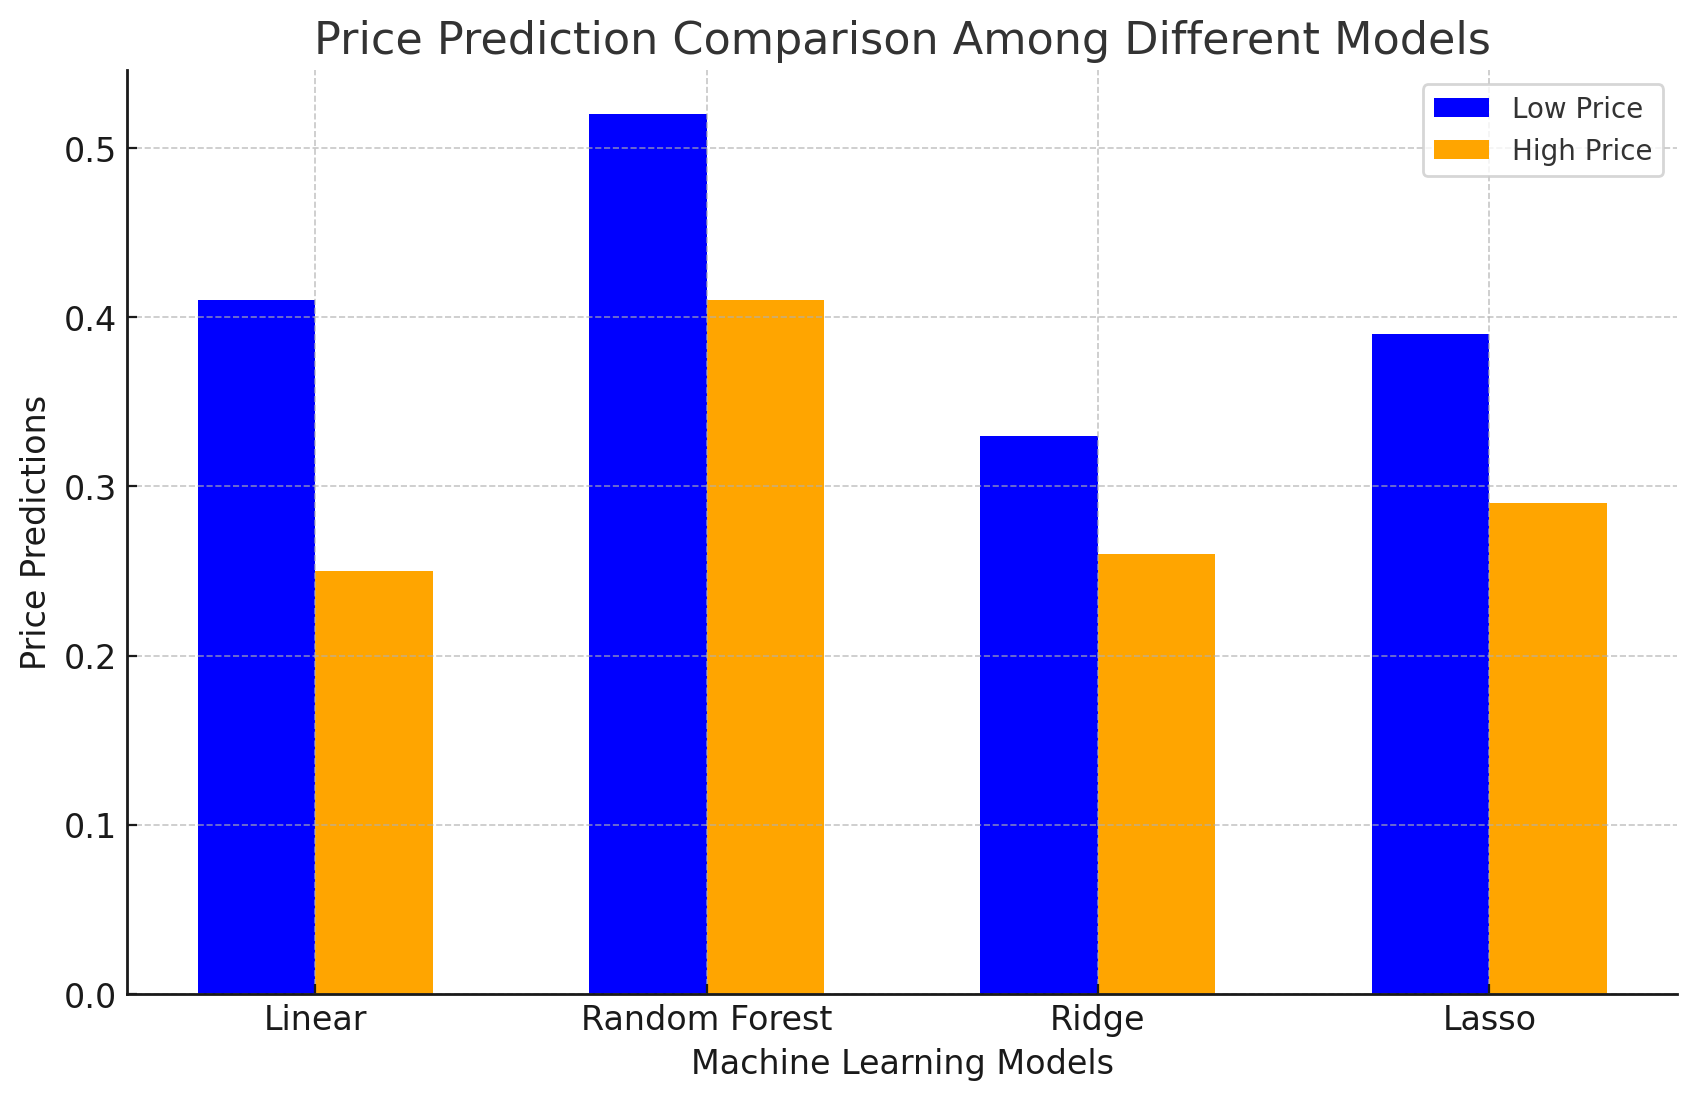
* Using categorical ecnoded data did not improve the model. (According to the results in the section 4 and the section 5. Results in the section 4 are better and the results in the section 5)
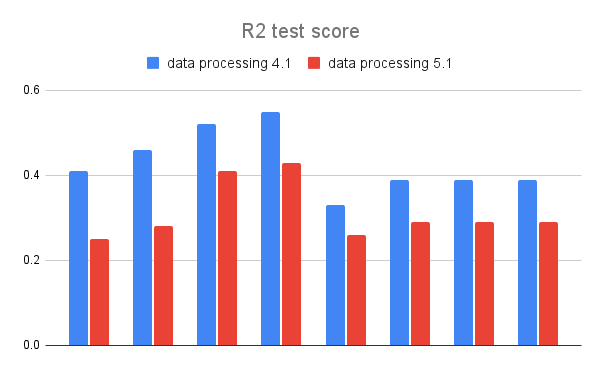
* The three features "Number of bedrooms", "number of beds", "Number of baths" are significant factors.If without them,  in certain models R^2 score is even less than 0.1.

    

# 7.Reference

Python notebooks  

* https://www.kaggle.com/dgomonov/data-exploration-on-nyc-airbnb
* https://www.kaggle.com/biphili/hospitality-in-era-of-airbnb
* https://www.kaggle.com/chirag9073/airbnb-analysis-visualization-and-prediction   
* https://www.kaggle.com/jrw2200/smart-pricing-with-xgb-rfr-interpretations   
* https://www.kaggle.com/mpanfil/nyc-airbnb-data-science-ml-project  
* https://www.kaggle.com/elcaiseri/airbnb-data-exploration-on-nyc-visualization  
* https://www.kaggle.com/nidaguler/eda-and-data-visualization-ny-airbnb  
* https://www.kaggle.com/duygut/airbnb-nyc-price-prediction  

R notebooks

* https://www.kaggle.com/josipdomazet/mining-nyc-airbnb-data-using-r#data-visualisation   

Dataset discussion  

* https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data/discussion/112818#latest-649615  

Machine Learning Ressources  

* https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9   
* https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html   

General Data Science Ressources
* https://datascienceguide.github.io/exploratory-data-analysis
* https://jakevdp.github.io/PythonDataScienceHandbook/04.14-visualization-with-seaborn.html  
* http://seaborn.pydata.org/tutorial/color_palettes.html
* https://seaborn.pydata.org/tutorial.html
* https://seaborn.pydata.org/
* https://pandas.pydata.org/pandas-docs/stable/
* https://www.kaggle.com/neomatrix369/six-steps-to-more-professional-data-science-code